# Search for HARD-CODED for places where I put hard-coded numbers

In [1]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import itertools
import seaborn as sns
import geopandas as gpd
from shapely.ops import unary_union
import geoplot

In [17]:
from IPython.display import display, HTML

In [18]:
display(HTML(data = """
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

### Indicating results folders and creating labels for scenario figures

In [2]:
mainpath = '/Users/Kucuksayacigil/Dropbox/UCSD Postdoc/'
resultpath = mainpath + '/Results/'
data_repository = '/Users/Kucuksayacigil/Desktop/WECC-data/'

In [3]:
# The following is the input folder
inputfolder_1 = mainpath + '/Data/6-week data/Reference cost'
inputfolder_2 = data_repository + '/extra_inputs'

# The following folder's raw data will be used to generate singular figures (i.e., pertains to only one scenario)
# I could not solve this scenario with reference cost. Low cost nuclear leads to the same results. Hence, I am using low cost nuclear results.
# resultfolder = resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line)'
resultfolder = resultpath + '/Reference cost/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line)'

# The following folders' raw data will be used to generate figure for scenario comparison
# resultfolder_1 = resultpath + '/Reference cost/Results_m2050_tbaseline_pstate_rexpandedEIM_linear (no proposed line)'
# resultfolder_2 = resultpath + '/Reference cost/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line)'
# resultfolder_3 = resultpath + '/Reference cost/Results_m2050_tbaseline_pregionalces_rbaseline_linear (no proposed line)'
# resultfolder_4 = resultpath + '/Reference cost/Results_m2050_tbaseline_pregionalces_rexpandedEIM_linear (no proposed line)'
# resultfolder_5 = resultpath + '/Reference cost/Results_m2050_tbaseline_pregionalces_rregionalized_linear (no proposed line)'
resultfolder_1 = resultpath + '/Reference cost/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rexpandedEIM_linear (no proposed line)'
resultfolder_2 = resultpath + '/Reference cost/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line)'
resultfolder_3 = resultpath + '/Reference cost/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rbaseline_linear (no proposed line)'
resultfolder_4 = resultpath + '/Reference cost/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rexpandedEIM_linear (no proposed line)'
resultfolder_5 = resultpath + '/Reference cost/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rregionalized_linear (no proposed line)'

resultfolders = [resultfolder, resultfolder_1, resultfolder_2, resultfolder_3, resultfolder_4, resultfolder_5]

# The following folders' raw data will be used to generate figure for sensitivity comparison
# resultsense1 = resultpath + '/Low cost solar/Results_m2050_tbaseline_pregionalces_rbaseline_linear (no proposed line)'
# resultsense2 = resultpath + '/Low cost wind/Results_m2050_tbaseline_pregionalces_rbaseline_linear (no proposed line)'
# resultsense3 = resultpath + '/Low cost battery/Results_m2050_tbaseline_pregionalces_rbaseline_linear (no proposed line)'
# # resultsense4 = resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pregionalces_rbaseline_linear (no proposed line)'
# resultsense4 = resultpath + '/High cost gas/Results_m2050_tbaseline_pregionalces_rbaseline_linear (no proposed line)'
resultsense1 = resultpath + '/Low cost solar/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rbaseline_linear (no proposed line)'
resultsense2 = resultpath + '/Low cost wind/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rbaseline_linear (no proposed line)'
resultsense3 = resultpath + '/Low cost battery/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rbaseline_linear (no proposed line)'
# resultsense4 = resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pregionalces_rbaseline_linear (no proposed line)'
resultsense4 = resultpath + '/High cost gas/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rbaseline_linear (no proposed line)'

# resultsensefolders = [resultsense1, resultsense2, resultsense3, resultsense4, resultsense5]
resultsensefolders = [resultsense1, resultsense2, resultsense3, resultsense4]

In [4]:
scenario_names = []
for x in resultfolders:
    if x.split('/')[-1].split('_')[3][1:] == 'state':
        label_first = 'State Policy'
    elif x.split('/')[-1].split('_')[3][1:] == 'regionalces':
        label_first = 'Regional 100% CES'

    if x.split('/')[-1].split('_')[4][1:] == 'baseline':
        label_second = 'BAU'
    elif x.split('/')[-1].split('_')[4][1:] == 'expandedEIM':
        label_second = 'Expanded EIM'
    elif x.split('/')[-1].split('_')[4][1:] == 'regionalized':
        label_second = 'Regional Market'
        
    label_comp = label_second + ' + ' + label_first
    
    scenario_names.append(label_comp)

### Figure parameters

In [5]:
fig1 = 15
fig2 = 9
fs = 16
dpi_qual = 300
bar_width = 0.5

### Reading results 

In [6]:
def prepare_dataframe(path, namedf):
    data = pd.read_csv(os.path.join(path, namedf))
    data = data.transpose()
    data.columns = data.iloc[0] 
    data = data[1:]
    data = data / 1000
    return data

In [7]:
def prepare_dataframe2(path, namedf, unnecessary_rows):
    data = pd.read_csv(os.path.join(path, namedf))
    data.drop(data.tail(unnecessary_rows).index, inplace = True)
    del data['Index']
    data = data.set_index('Path')
    data = data / 1000
    return data

In [8]:
aggregated_cap = prepare_dataframe(resultfolder, "allcap_aggregate.csv")
aggregated_cap_1 = prepare_dataframe(resultfolder_1, "allcap_aggregate.csv")
aggregated_cap_2 = prepare_dataframe(resultfolder_2, "allcap_aggregate.csv")
aggregated_cap_3 = prepare_dataframe(resultfolder_3, "allcap_aggregate.csv")
aggregated_cap_4 = prepare_dataframe(resultfolder_4, "allcap_aggregate.csv")
aggregated_cap_5 = prepare_dataframe(resultfolder_5, "allcap_aggregate.csv")

aggregated_cap_scenario = [aggregated_cap, aggregated_cap_1, aggregated_cap_2, aggregated_cap_3, 
                                           aggregated_cap_4, aggregated_cap_5]

aggregated_cap_sense1 = prepare_dataframe(resultsense1, "allcap_aggregate.csv")
aggregated_cap_sense2 = prepare_dataframe(resultsense2, "allcap_aggregate.csv")
aggregated_cap_sense3 = prepare_dataframe(resultsense3, "allcap_aggregate.csv")
aggregated_cap_sense4 = prepare_dataframe(resultsense4, "allcap_aggregate.csv")
# aggregated_cap_sense5 = prepare_dataframe(resultsense5, "allcap_aggregate.csv")

# aggregated_cap_sense = [aggregated_cap_sense1, aggregated_cap_sense2, aggregated_cap_sense3, 
#                         aggregated_cap_sense4, aggregated_cap_sense5]
aggregated_cap_sense = [aggregated_cap_sense1, aggregated_cap_sense2, aggregated_cap_sense3, 
                        aggregated_cap_sense4]

cost = pd.read_csv(os.path.join(resultfolder, "cost_components.csv"))
cost_1 = pd.read_csv(os.path.join(resultfolder_1, "cost_components.csv"))
cost_2 = pd.read_csv(os.path.join(resultfolder_2, "cost_components.csv"))
cost_3 = pd.read_csv(os.path.join(resultfolder_3, "cost_components.csv"))
cost_4 = pd.read_csv(os.path.join(resultfolder_4, "cost_components.csv"))
cost_5 = pd.read_csv(os.path.join(resultfolder_5, "cost_components.csv"))

curtailment = pd.read_csv(os.path.join(resultfolder_3, "final_curtailment.csv"))

allcap = pd.read_csv(os.path.join(resultfolder, "allcap.csv"))
allcap_1 = pd.read_csv(os.path.join(resultfolder_1, "allcap.csv"))
allcap_2 = pd.read_csv(os.path.join(resultfolder_2, "allcap.csv"))
allcap_3 = pd.read_csv(os.path.join(resultfolder_3, "allcap.csv"))
allcap_4 = pd.read_csv(os.path.join(resultfolder_4, "allcap.csv"))
allcap_5 = pd.read_csv(os.path.join(resultfolder_5, "allcap.csv"))
allcap.OptValues = allcap.OptValues / 1000
allcap_1.OptValues = allcap_1.OptValues / 1000
allcap_2.OptValues = allcap_2.OptValues / 1000
allcap_3.OptValues = allcap_3.OptValues / 1000
allcap_4.OptValues = allcap_4.OptValues / 1000
allcap_5.OptValues = allcap_5.OptValues / 1000

allcap_scenario = [allcap, allcap_1, allcap_2, allcap_3, allcap_4, allcap_5]

network = pd.read_csv(os.path.join(inputfolder_1, "Network.csv"))

pronetwork = pd.read_csv(os.path.join(inputfolder_2, "new_transmission_lines.csv"))

totalline_cap = prepare_dataframe2(resultfolder, "vCAPLINE_results.csv", len(pronetwork))
totalline_cap_1 = prepare_dataframe2(resultfolder_1, "vCAPLINE_results.csv", len(pronetwork))
totalline_cap_2 = prepare_dataframe2(resultfolder_2, "vCAPLINE_results.csv", len(pronetwork))
totalline_cap_3 = prepare_dataframe2(resultfolder_3, "vCAPLINE_results.csv", len(pronetwork))
totalline_cap_4 = prepare_dataframe2(resultfolder_4, "vCAPLINE_results.csv", len(pronetwork))
totalline_cap_5 = prepare_dataframe2(resultfolder_5, "vCAPLINE_results.csv", len(pronetwork))

totalline_cap_scenario = [totalline_cap, totalline_cap_1, totalline_cap_2, totalline_cap_3,
                          totalline_cap_4, totalline_cap_5]

flow = pd.read_csv(os.path.join(resultfolder_3, "vFLOW_results.csv"))
del flow['Index']
flow = flow.set_index('Path')
flow = flow / 1000

load =  pd.read_csv(os.path.join(inputfolder_1, "Load_data.csv"))

generators = pd.read_csv(os.path.join(inputfolder_1, "Generators_data.csv"))

wecczone_shapes = gpd.read_file(os.path.join(data_repository, "../wecczone_shapes/wecczone_shapes.shp"))
states_shape = gpd.read_file(os.path.join(data_repository, "state_shape/cb_2018_us_state_20m.shp"))

dispatch = pd.read_csv(os.path.join(resultfolder_3, "Dispatch/dispatch_summary.csv"))

hurdle = pd.read_csv(os.path.join(inputfolder_2, "hurdle_rates.csv"))

totalline_cap_sense1 = prepare_dataframe2(resultsense1, "vCAPLINE_results.csv", len(pronetwork))
totalline_cap_sense2 = prepare_dataframe2(resultsense2, "vCAPLINE_results.csv", len(pronetwork))
totalline_cap_sense3 = prepare_dataframe2(resultsense3, "vCAPLINE_results.csv", len(pronetwork))
totalline_cap_sense4 = prepare_dataframe2(resultsense4, "vCAPLINE_results.csv", len(pronetwork))
# totalline_cap_sense5 = prepare_dataframe2(resultsense5, "vCAPLINE_results.csv", len(pronetwork))

# totalline_cap_sense = [totalline_cap_sense1, totalline_cap_sense2, totalline_cap_sense3, 
#                        totalline_cap_sense4, totalline_cap_sense5]
totalline_cap_sense = [totalline_cap_sense1, totalline_cap_sense2, totalline_cap_sense3, 
                       totalline_cap_sense4]

In [9]:
cost_state_bau_limited_ls = pd.read_csv(resultpath + '/Low cost solar/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line, expand grid only through proposed paths and do not exceed proposed capacities)/cost_components.csv')
cost_state_bau_limited_lw = pd.read_csv(resultpath + '/Low cost wind/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line, expand grid only through proposed paths and do not exceed proposed capacities)/cost_components.csv')
cost_state_bau_limited_lb = pd.read_csv(resultpath + '/Low cost battery/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line, expand grid only through proposed paths and do not exceed proposed capacities)/cost_components.csv')
cost_state_bau_limited_hg = pd.read_csv(resultpath + '/High cost gas/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line, expand grid only through proposed paths and do not exceed proposed capacities)/cost_components.csv')

# cost_state_bau_ls = pd.read_csv(resultpath + '/Low cost solar/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line)/cost_components.csv')
# cost_state_bau_lw = pd.read_csv(resultpath + '/Low cost wind/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line)/cost_components.csv')
# cost_state_bau_lb = pd.read_csv(resultpath + '/Low cost battery/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line)/cost_components.csv')
# # cost_state_bau_ln = pd.read_csv(resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line)/cost_components.csv')
# cost_state_bau_hg = pd.read_csv(resultpath + '/High cost gas/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line)/cost_components.csv')
cost_state_bau_ls = pd.read_csv(resultpath + '/Low cost solar/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line)/cost_components.csv')
cost_state_bau_lw = pd.read_csv(resultpath + '/Low cost wind/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line)/cost_components.csv')
cost_state_bau_lb = pd.read_csv(resultpath + '/Low cost battery/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line)/cost_components.csv')
# cost_state_bau_ln = pd.read_csv(resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line)/cost_components.csv')
cost_state_bau_hg = pd.read_csv(resultpath + '/High cost gas/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line)/cost_components.csv')

# cost_state_expandedeim_ls = pd.read_csv(resultpath + '/Low cost solar/Results_m2050_tbaseline_pstate_rexpandedEIM_linear (no proposed line)/cost_components.csv')
# cost_state_expandedeim_lw = pd.read_csv(resultpath + '/Low cost wind/Results_m2050_tbaseline_pstate_rexpandedEIM_linear (no proposed line)/cost_components.csv')
# cost_state_expandedeim_lb = pd.read_csv(resultpath + '/Low cost battery/Results_m2050_tbaseline_pstate_rexpandedEIM_linear (no proposed line)/cost_components.csv')
# # cost_state_expandedeim_ln = pd.read_csv(resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line)/cost_components.csv')
# cost_state_expandedeim_hg = pd.read_csv(resultpath + '/High cost gas/Results_m2050_tbaseline_pstate_rexpandedEIM_linear (no proposed line)/cost_components.csv')
cost_state_expandedeim_ls = pd.read_csv(resultpath + '/Low cost solar/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rexpandedEIM_linear (no proposed line)/cost_components.csv')
cost_state_expandedeim_lw = pd.read_csv(resultpath + '/Low cost wind/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rexpandedEIM_linear (no proposed line)/cost_components.csv')
cost_state_expandedeim_lb = pd.read_csv(resultpath + '/Low cost battery/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rexpandedEIM_linear (no proposed line)/cost_components.csv')
# cost_state_expandedeim_ln = pd.read_csv(resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pstate_rbaseline_linear (no proposed line)/cost_components.csv')
cost_state_expandedeim_hg = pd.read_csv(resultpath + '/High cost gas/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rexpandedEIM_linear (no proposed line)/cost_components.csv')

# cost_state_regionalized_ls = pd.read_csv(resultpath + '/Low cost solar/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line)/cost_components.csv')
# cost_state_regionalized_lw = pd.read_csv(resultpath + '/Low cost wind/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line)/cost_components.csv')
# cost_state_regionalized_lb = pd.read_csv(resultpath + '/Low cost battery/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line)/cost_components.csv')
# # cost_state_regionalized_ln = pd.read_csv(resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line)/cost_components.csv')
# cost_state_regionalized_hg = pd.read_csv(resultpath + '/High cost gas/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line)/cost_components.csv')
cost_state_regionalized_ls = pd.read_csv(resultpath + '/Low cost solar/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line)/cost_components.csv')
cost_state_regionalized_lw = pd.read_csv(resultpath + '/Low cost wind/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line)/cost_components.csv')
cost_state_regionalized_lb = pd.read_csv(resultpath + '/Low cost battery/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line)/cost_components.csv')
# cost_state_regionalized_ln = pd.read_csv(resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line)/cost_components.csv')
cost_state_regionalized_hg = pd.read_csv(resultpath + '/High cost gas/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line)/cost_components.csv')

# cost_state_regionalized_zeroper_ls = pd.read_csv(resultpath + '/Low cost solar/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line, in-state RPS = 0)/cost_components.csv')
# cost_state_regionalized_zeroper_lw = pd.read_csv(resultpath + '/Low cost wind/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line, in-state RPS = 0)/cost_components.csv')
# cost_state_regionalized_zeroper_lb = pd.read_csv(resultpath + '/Low cost battery/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line, in-state RPS = 0)/cost_components.csv')
# # cost_state_regionalized_ln = pd.read_csv(resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line)/cost_components.csv')
# cost_state_regionalized_zeroper_hg = pd.read_csv(resultpath + '/High cost gas/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line, in-state RPS = 0)/cost_components.csv')
cost_state_regionalized_zeroper_ls = pd.read_csv(resultpath + '/Low cost solar/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line, in-state RPS = 0)/cost_components.csv')
cost_state_regionalized_zeroper_lw = pd.read_csv(resultpath + '/Low cost wind/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line, in-state RPS = 0)/cost_components.csv')
cost_state_regionalized_zeroper_lb = pd.read_csv(resultpath + '/Low cost battery/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line, in-state RPS = 0)/cost_components.csv')
# cost_state_regionalized_ln = pd.read_csv(resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line)/cost_components.csv')
cost_state_regionalized_zeroper_hg = pd.read_csv(resultpath + '/High cost gas/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pstate_rregionalized_linear (no proposed line, in-state RPS = 0)/cost_components.csv')

cost_ces_bau_ls = pd.read_csv(os.path.join(resultsense1, "cost_components.csv"))
cost_ces_bau_lw = pd.read_csv(os.path.join(resultsense2, "cost_components.csv"))
cost_ces_bau_lb = pd.read_csv(os.path.join(resultsense3, "cost_components.csv"))
# cost_ces_bau_ln = pd.read_csv(os.path.join(resultsense4, "cost_components.csv"))
cost_ces_bau_hg = pd.read_csv(os.path.join(resultsense4, "cost_components.csv"))

# cost_ces_expandedeim_ls = pd.read_csv(resultpath + '/Low cost solar/Results_m2050_tbaseline_pregionalces_rexpandedEIM_linear (no proposed line)/cost_components.csv')
# cost_ces_expandedeim_lw = pd.read_csv(resultpath + '/Low cost wind/Results_m2050_tbaseline_pregionalces_rexpandedEIM_linear (no proposed line)/cost_components.csv')
# cost_ces_expandedeim_lb = pd.read_csv(resultpath + '/Low cost battery/Results_m2050_tbaseline_pregionalces_rexpandedEIM_linear (no proposed line)/cost_components.csv')
# # cost_ces_expandedeim_ln = pd.read_csv(resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pregionalces_rexpandedEIM_linear (no proposed line)/cost_components.csv')
# cost_ces_expandedeim_hg = pd.read_csv(resultpath + '/High cost gas/Results_m2050_tbaseline_pregionalces_rexpandedEIM_linear (no proposed line)/cost_components.csv')
cost_ces_expandedeim_ls = pd.read_csv(resultpath + '/Low cost solar/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rexpandedEIM_linear (no proposed line)/cost_components.csv')
cost_ces_expandedeim_lw = pd.read_csv(resultpath + '/Low cost wind/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rexpandedEIM_linear (no proposed line)/cost_components.csv')
cost_ces_expandedeim_lb = pd.read_csv(resultpath + '/Low cost battery/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rexpandedEIM_linear (no proposed line)/cost_components.csv')
# cost_ces_expandedeim_ln = pd.read_csv(resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pregionalces_rexpandedEIM_linear (no proposed line)/cost_components.csv')
cost_ces_expandedeim_hg = pd.read_csv(resultpath + '/High cost gas/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rexpandedEIM_linear (no proposed line)/cost_components.csv')

# cost_ces_regionalized_ls = pd.read_csv(resultpath + '/Low cost solar/Results_m2050_tbaseline_pregionalces_rregionalized_linear (no proposed line)/cost_components.csv')
# cost_ces_regionalized_lw = pd.read_csv(resultpath + '/Low cost wind/Results_m2050_tbaseline_pregionalces_rregionalized_linear (no proposed line)/cost_components.csv')
# cost_ces_regionalized_lb = pd.read_csv(resultpath + '/Low cost battery/Results_m2050_tbaseline_pregionalces_rregionalized_linear (no proposed line)/cost_components.csv')
# # cost_ces_regionalized_ln = pd.read_csv(resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pregionalces_rregionalized_linear (no proposed line)/cost_components.csv')
# cost_ces_regionalized_hg = pd.read_csv(resultpath + '/High cost gas/Results_m2050_tbaseline_pregionalces_rregionalized_linear (no proposed line)/cost_components.csv')
cost_ces_regionalized_ls = pd.read_csv(resultpath + '/Low cost solar/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rregionalized_linear (no proposed line)/cost_components.csv')
cost_ces_regionalized_lw = pd.read_csv(resultpath + '/Low cost wind/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rregionalized_linear (no proposed line)/cost_components.csv')
cost_ces_regionalized_lb = pd.read_csv(resultpath + '/Low cost battery/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rregionalized_linear (no proposed line)/cost_components.csv')
# cost_ces_regionalized_ln = pd.read_csv(resultpath + '/Low cost nuclear/Results_m2050_tbaseline_pregionalces_rregionalized_linear (no proposed line)/cost_components.csv')
cost_ces_regionalized_hg = pd.read_csv(resultpath + '/High cost gas/New state-policy formulation (for regionalization paper)/Results_m2050_tbaseline_pregionalces_rregionalized_linear (no proposed line)/cost_components.csv')

# lcs = [sum(cost_state_bau_ls.Values) / 100000, sum(cost_state_expandedeim_ls.Values) / 100000, sum(cost_state_regionalized_ls.Values) / 100000, sum(cost_ces_bau_ls.Values) / 100000, sum(cost_ces_expandedeim_ls.Values) / 100000, sum(cost_ces_regionalized_ls.Values) / 100000]
# lcs = [sum(cost_state_bau_ls.Values) / 100000, sum(cost_state_expandedeim_ls.Values) / 100000, sum(cost_state_regionalized_ls.Values) / 100000, sum(cost_state_regionalized_zeroper_ls.Values) / 100000, sum(cost_ces_bau_ls.Values) / 100000, sum(cost_ces_expandedeim_ls.Values) / 100000, sum(cost_ces_regionalized_ls.Values) / 100000]
lcs = [sum(cost_state_bau_limited_ls.Values) / 100000, sum(cost_state_bau_ls.Values) / 100000, sum(cost_state_expandedeim_ls.Values) / 100000, sum(cost_state_regionalized_ls.Values) / 100000, sum(cost_state_regionalized_zeroper_ls.Values) / 100000, sum(cost_ces_bau_ls.Values) / 100000, sum(cost_ces_expandedeim_ls.Values) / 100000, sum(cost_ces_regionalized_ls.Values) / 100000]
# lcw = [None, sum(cost_state_expandedeim_lw.Values) / 100000, sum(cost_state_regionalized_lw.Values) / 100000, sum(cost_ces_bau_lw.Values) / 100000, sum(cost_ces_expandedeim_lw.Values) / 100000, sum(cost_ces_regionalized_lw.Values) / 100000]
# lcw = [None, sum(cost_state_expandedeim_lw.Values) / 100000, sum(cost_state_regionalized_lw.Values) / 100000, sum(cost_state_regionalized_zeroper_lw.Values) / 100000, sum(cost_ces_bau_lw.Values) / 100000, sum(cost_ces_expandedeim_lw.Values) / 100000, sum(cost_ces_regionalized_lw.Values) / 100000]
lcw = [sum(cost_state_bau_limited_lw.Values) / 100000, sum(cost_state_bau_lw.Values) / 100000, sum(cost_state_expandedeim_lw.Values) / 100000, sum(cost_state_regionalized_lw.Values) / 100000, sum(cost_state_regionalized_zeroper_lw.Values) / 100000, sum(cost_ces_bau_lw.Values) / 100000, sum(cost_ces_expandedeim_lw.Values) / 100000, sum(cost_ces_regionalized_lw.Values) / 100000]
# lcb = [sum(cost_state_bau_lb.Values) / 100000, sum(cost_state_expandedeim_lb.Values) / 100000, sum(cost_state_regionalized_lb.Values) / 100000, sum(cost_ces_bau_lb.Values) / 100000, sum(cost_ces_expandedeim_lb.Values) / 100000, sum(cost_ces_regionalized_lb.Values) / 100000]
# lcb = [sum(cost_state_bau_lb.Values) / 100000, sum(cost_state_expandedeim_lb.Values) / 100000, sum(cost_state_regionalized_lb.Values) / 100000, sum(cost_state_regionalized_zeroper_lb.Values) / 100000, sum(cost_ces_bau_lb.Values) / 100000, sum(cost_ces_expandedeim_lb.Values) / 100000, sum(cost_ces_regionalized_lb.Values) / 100000]
lcb = [sum(cost_state_bau_limited_lb.Values) / 100000, sum(cost_state_bau_lb.Values) / 100000, sum(cost_state_expandedeim_lb.Values) / 100000, sum(cost_state_regionalized_lb.Values) / 100000, sum(cost_state_regionalized_zeroper_lb.Values) / 100000, sum(cost_ces_bau_lb.Values) / 100000, sum(cost_ces_expandedeim_lb.Values) / 100000, sum(cost_ces_regionalized_lb.Values) / 100000]
# lcn = [sum(cost_state_bau_ln.Values) / 100000, sum(cost_state_expandedeim_ln.Values) / 100000, sum(cost_state_regionalized_ln.Values) / 100000, sum(cost_ces_bau_ln.Values) / 100000, sum(cost_ces_expandedeim_ln.Values) / 100000, sum(cost_ces_regionalized_ln.Values) / 100000]
# hcg = [sum(cost_state_bau_hg.Values) / 100000, sum(cost_state_expandedeim_hg.Values) / 100000, sum(cost_state_regionalized_hg.Values) / 100000, sum(cost_ces_bau_hg.Values) / 100000, sum(cost_ces_expandedeim_hg.Values) / 100000, sum(cost_ces_regionalized_hg.Values) / 100000]
# hcg = [sum(cost_state_bau_hg.Values) / 100000, sum(cost_state_expandedeim_hg.Values) / 100000, sum(cost_state_regionalized_hg.Values) / 100000, sum(cost_state_regionalized_zeroper_hg.Values) / 100000, sum(cost_ces_bau_hg.Values) / 100000, sum(cost_ces_expandedeim_hg.Values) / 100000, sum(cost_ces_regionalized_hg.Values) / 100000]
hcg = [sum(cost_state_bau_limited_hg.Values) / 100000, sum(cost_state_bau_hg.Values) / 100000, sum(cost_state_expandedeim_hg.Values) / 100000, sum(cost_state_regionalized_hg.Values) / 100000, sum(cost_state_regionalized_zeroper_hg.Values) / 100000, sum(cost_ces_bau_hg.Values) / 100000, sum(cost_ces_expandedeim_hg.Values) / 100000, sum(cost_ces_regionalized_hg.Values) / 100000]

### Create region description data

In [13]:
region_name, region_code = [], []
for x in range(1,len(np.unique(generators.region)) + 1):
    region_name.append(generators.loc[generators['Zone'] == x]['region'].tolist()[0])
    region_code.append("z" + str(x))
    
regiondf = pd.DataFrame({'Code':region_code, 'Region':region_name})

In [14]:
linedirect = [network[['z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10', 'z11', 'z12']],
           pronetwork[['z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10', 'z11', 'z12']]]
linenum = pd.concat(linedirect)
linenum.index = list(range(0,len(linenum)))

### Storage capacities in 100% CES + BAU scenario

In [12]:
battery_full = pd.merge(allcap_3[allcap_3['Resource'].str.contains('batteries')],
                        allcap_3[allcap_3['Resource'].str.contains('battery')],
                        how = 'outer', on = 'Region')

battery_sum = pd.DataFrame(battery_full.fillna(0)['OptValues_x'] + battery_full.fillna(0)['OptValues_y'],
                            columns = ['Battery'])
battery_sum['Region'] = battery_full.Region

In [13]:
pumped_full = pd.merge(allcap_3[allcap_3['Resource'].str.contains('hydroelectric_pumped')],
                        allcap_3[allcap_3['Resource'].str.contains('newpumped')],
                        how = 'outer', on = 'Region')

pumped_sum = pd.DataFrame(pumped_full.fillna(0)['OptValues_x'] + pumped_full.fillna(0)['OptValues_y'],
                            columns = ['Pumped Hydro'])
pumped_sum['Region'] = pumped_full.Region

In [14]:
thermal_sum = pd.DataFrame(allcap_3[allcap_3['Resource'].str.contains('thermal_with_')]['OptValues'].tolist(), 
                           columns = ['Solar Thermal'])
thermal_sum['Region'] = allcap_3[allcap_3['Resource'].str.contains('thermal_with_')]['Region'].tolist()

In [15]:
tempdf = pd.merge(battery_sum, pumped_sum, how = 'outer', on = 'Region')
finalstordf = pd.merge(tempdf, thermal_sum, how = 'outer', on = 'Region')
finalstordf = finalstordf.fillna(0)
finalstordf = finalstordf.set_index('Region')
finalstordf = finalstordf.reindex(aggregated_cap_3.index)

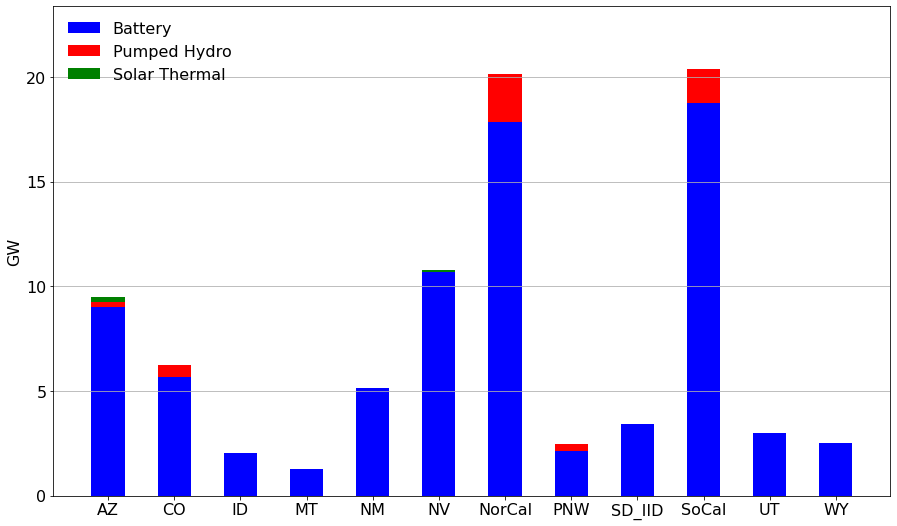

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (fig1, fig2))
ax.bar(finalstordf.index, finalstordf.Battery, width = bar_width, label = 'Battery', color = 'blue')
ax.bar(finalstordf.index, finalstordf['Pumped Hydro'], width = bar_width, label = 'Pumped Hydro', color = 'red', bottom = finalstordf.Battery)
ax.bar(finalstordf.index, finalstordf['Solar Thermal'], width = bar_width, label = 'Solar Thermal', color = 'green', bottom = finalstordf.Battery + finalstordf['Pumped Hydro'])

ax.set_ylabel('GW', fontsize = fs)
ax.tick_params(axis = 'y', labelsize = fs)
ax.tick_params(axis = 'x', labelsize = fs)
ax.set_ylim(0, max(finalstordf.Battery + finalstordf['Pumped Hydro'] + finalstordf['Solar Thermal']) + 3)
ax.yaxis.grid()
ax.legend(fontsize = fs, frameon = False)
plt.savefig(os.path.join(resultpath, "Regionalization paper", "storage_capacities.pdf"), dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### Flow on a typical day in 100% CES + BAU scenario

In [17]:
typical_day = flow.iloc[:,216:240]
flowsum = np.zeros((len(regiondf), typical_day.shape[1]))
for (index, colname) in enumerate(linenum):
    flowsum[index] = typical_day.mul(linenum[colname].tolist(), axis = 0).sum(axis = 0)

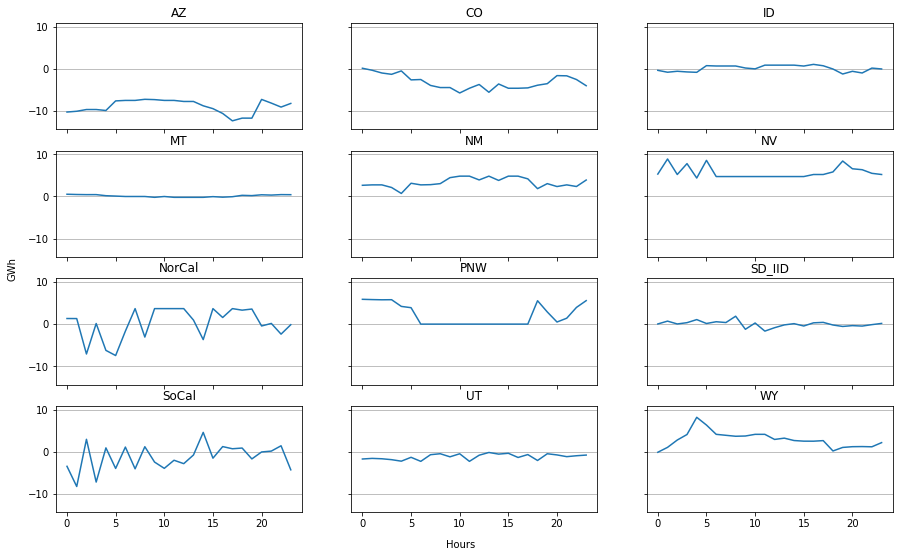

In [18]:
nrow, ncol = 4, 3
ccount = 0
fig, ax = plt.subplots(nrow, ncol, figsize = (fig1, fig2))
for x in range(0,nrow):
    for y in range(0,ncol):
        ax[x,y].plot(flowsum[ccount])
        ax[x,y].set_ylim(flowsum.min() - 2, flowsum.max() + 2)
        ax[x,y].set_title(regiondf.Region[ccount])
        ax[x,y].yaxis.grid()
        if x != nrow - 1:
            ax[x,y].axes.xaxis.set_ticklabels([])
        if y != 0:
            ax[x,y].axes.yaxis.set_ticklabels([])
        ccount = ccount + 1

fig.text(0.5, 0.07, 'Hours', ha = 'center')
fig.text(0.08, 0.5, 'GWh', va = 'center', rotation = 'vertical')
plt.savefig(os.path.join(resultpath, "Regionalization paper", "flow.pdf"), dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### Curtailment in 100% CES + BAU scenario

In [18]:
# curtailment = pd.read_csv(os.path.join(resultfolder_5, "final_curtailment.csv"))

In [19]:
curtailment = curtailment.set_index('Region')
ind = np.arange(len(curtailment.index))
curtailment = curtailment * 100

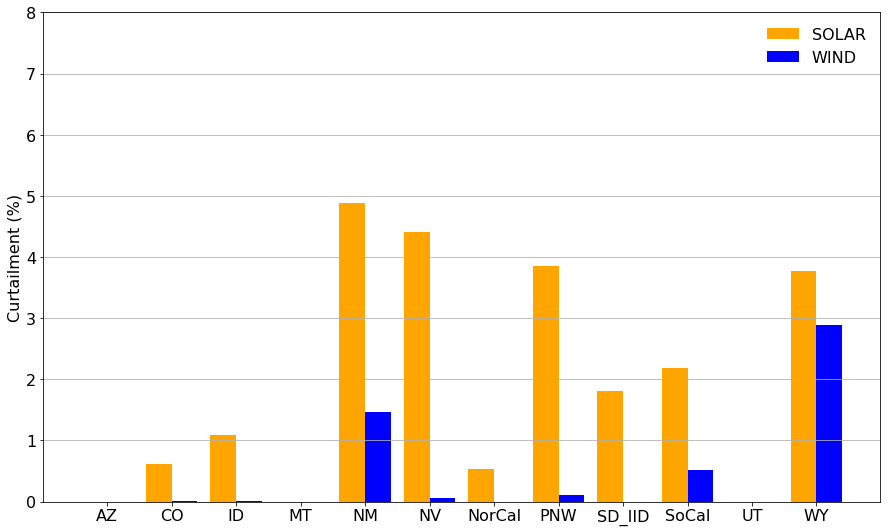

In [20]:
bar_space_cur = 0.4

fig, ax = plt.subplots(1, 1, figsize = (fig1, fig2))
ax.bar(ind, curtailment.SOLAR, width = bar_space_cur, label = 'SOLAR', color = 'orange')
ax.bar(ind + bar_space_cur, curtailment.WIND, width = bar_space_cur, label = 'WIND', color = 'blue')
ax.set_ylabel('Curtailment (%)', fontsize = fs)
ax.tick_params(axis = 'y', labelsize = fs)
ax.tick_params(axis = 'x', labelsize = fs)
ax.set_xticks(ind + bar_space_cur / 2)
ax.set_xticklabels(curtailment.index)
ax.set_ylim([0,8])
ax.yaxis.grid()
ax.legend(fontsize = fs, frameon = False)
plt.savefig(os.path.join(resultpath, "Regionalization paper", "curtailment_regional_ces.pdf"), dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### Costs in scenarios

In [21]:
total_cost_no_coordination = 38.96 # (BAU, 75% in-state, transmission expansion only through proposed lines) in state policy HARD-CODED
total_cost = sum(cost.Values) / 100000
total_cost_1 = sum(cost_1.Values) / 100000
total_cost_2 = sum(cost_2.Values) / 100000
total_cost_instate = 35.71 # This refers to sensitivity analysis with 0% in-state RPS and CES requirements HARD-CODED
total_cost_3 = sum(cost_3.Values) / 100000
total_cost_4 = sum(cost_4.Values) / 100000
total_cost_5 = sum(cost_5.Values) / 100000
# cost_values = [total_cost, total_cost_1, total_cost_2, total_cost_3, total_cost_4, total_cost_5]
cost_values = [total_cost_no_coordination, total_cost, total_cost_1, total_cost_2, total_cost_instate, total_cost_3, total_cost_4, total_cost_5]

In [22]:
scenario_names_updated = ['BAU \n No Coordination in \n Transmission Expansion', 'BAU', 'Expanded EIM', 'Regional Market', 'Regional Market \n 0% In-State RPS and CES', 
                          'BAU', 'Expanded EIM', 'Regional Market']

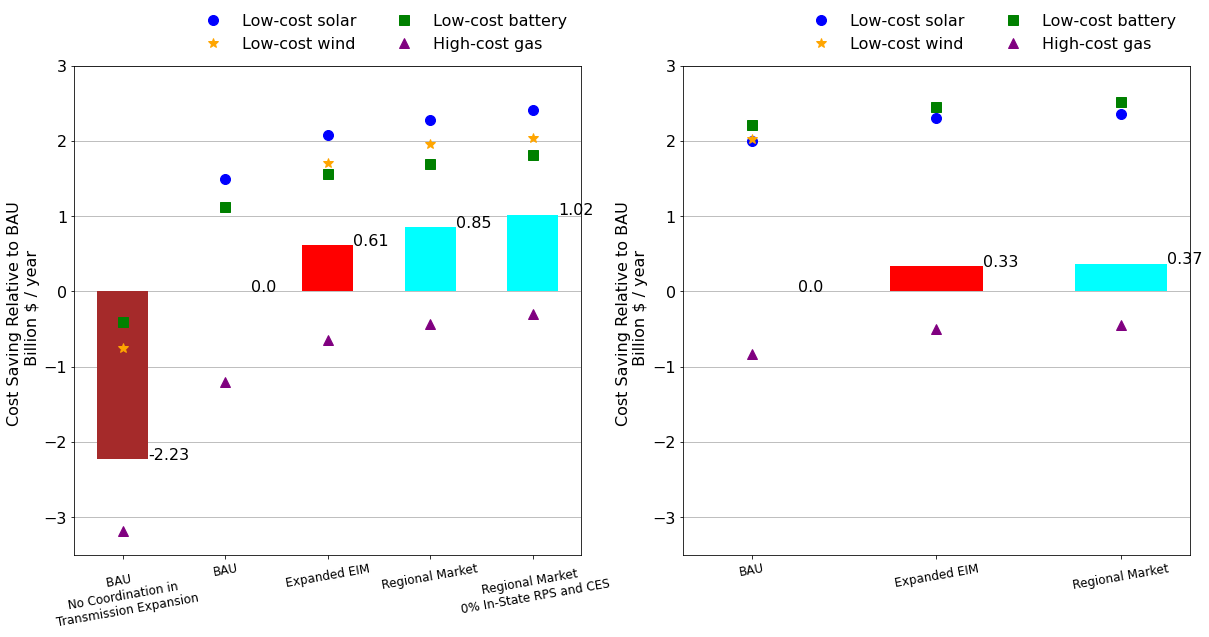

In [23]:
ind = np.arange(len(scenario_names_updated))

fig, ax = plt.subplots(1, 2, figsize = (20, fig2))

# ax.bar(scenario_names, cost_values, width = bar_width, color = ['blue', 'red', 'yellow', 'yellow', 'blue', 'red', 'yellow'])
ax[0].bar(ind[0:5], [total_cost - x for x in cost_values[0:5]], width = bar_width, color = ['brown', 'brown', 'red', 'cyan', 'cyan'], zorder = 2)
ax[1].bar(ind[0:3], [total_cost_3 - x for x in cost_values[5:8]], width = bar_width, color = ['brown', 'red', 'cyan'], zorder = 2)

# ax[0].plot(lcs[0:4], marker = 'o', markersize = 10, linestyle = "None", label = 'Low-cost solar', color = 'blue')
# ax[0].plot(lcw[0:4], marker = '*', markersize = 10, linestyle = "None", label = 'Low-cost wind', color = 'orange')
# ax[0].plot(lcb[0:4], marker = 's', markersize = 10, linestyle = "None", label = 'Low-cost battery', color = 'green')
# # ax.plot(lcn, marker = 'D', markersize = 10, linestyle = "None", label = 'Low cost nuclear', color = 'red')
# ax[0].plot(hcg[0:4], marker = '^', markersize = 10, linestyle = "None", label = 'High-cost gas', color = 'purple')
ax[0].plot([total_cost - x for x in lcs[0:5]], marker = 'o', markersize = 10, linestyle = "None", label = 'Low-cost solar', color = 'blue')
ax[0].plot([total_cost - x for x in lcw[0:5]], marker = '*', markersize = 10, linestyle = "None", label = 'Low-cost wind', color = 'orange')
ax[0].plot([total_cost - x for x in lcb[0:5]], marker = 's', markersize = 10, linestyle = "None", label = 'Low-cost battery', color = 'green')
# ax.plot(lcn, marker = 'D', markersize = 10, linestyle = "None", label = 'Low cost nuclear', color = 'red')
ax[0].plot([total_cost - x for x in hcg[0:5]], marker = '^', markersize = 10, linestyle = "None", label = 'High-cost gas', color = 'purple')

# ax[1].plot(lcs[4:7], marker = 'o', markersize = 10, linestyle = "None", label = 'Low-cost solar', color = 'blue')
# ax[1].plot(lcw[4:7], marker = '*', markersize = 10, linestyle = "None", label = 'Low-cost wind', color = 'orange')
# ax[1].plot(lcb[4:7], marker = 's', markersize = 10, linestyle = "None", label = 'Low-cost battery', color = 'green')
# # ax.plot(lcn, marker = 'D', markersize = 10, linestyle = "None", label = 'Low cost nuclear', color = 'red')
# ax[1].plot(hcg[4:7], marker = '^', markersize = 10, linestyle = "None", label = 'High-cost gas', color = 'purple')
ax[1].plot([total_cost_3 - x for x in lcs[5:8]], marker = 'o', markersize = 10, linestyle = "None", label = 'Low-cost solar', color = 'blue')
ax[1].plot([total_cost_3 - x for x in lcw[5:8]], marker = '*', markersize = 10, linestyle = "None", label = 'Low-cost wind', color = 'orange')
ax[1].plot([total_cost_3 - x for x in lcb[5:8]], marker = 's', markersize = 10, linestyle = "None", label = 'Low-cost battery', color = 'green')
# ax.plot(lcn, marker = 'D', markersize = 10, linestyle = "None", label = 'Low cost nuclear', color = 'red')
ax[1].plot([total_cost_3 - x for x in hcg[5:8]], marker = '^', markersize = 10, linestyle = "None", label = 'High-cost gas', color = 'purple')

ax[0].set_xticks(ind[0:5])
ax[0].set_xticklabels(scenario_names_updated[0:5])
ax[0].set_ylabel('Cost Saving Relative to BAU \n Billion $ / year', fontsize = fs)
ax[0].tick_params(axis = 'y', labelsize = fs)
ax[0].tick_params(axis = 'x', labelsize = 11)
ax[0].yaxis.grid(zorder = 0)
ax[0].legend(fontsize = fs, frameon = False, ncol = 2, bbox_to_anchor = (1, 1), loc = "lower right")
ax[0].set_ylim(-3.5, 3)
ax[0].tick_params(axis = 'x', labelsize = 12, rotation = 10)

ax[1].set_xticks(ind[0:3])
ax[1].set_xticklabels(scenario_names_updated[5:8])
ax[1].set_ylabel('Cost Saving Relative to BAU \n Billion $ / year', fontsize = fs)
ax[1].tick_params(axis = 'y', labelsize = fs)
ax[1].tick_params(axis = 'x', labelsize = 11)
ax[1].yaxis.grid(zorder = 0)
ax[1].legend(fontsize = fs, frameon = False, ncol = 2, bbox_to_anchor = (1, 1), loc = "lower right")
ax[1].set_ylim(-3.5, 3)
ax[1].tick_params(axis = 'x', labelsize = 12, rotation = 10)

# ax.axvspan(plt.gca().get_xlim()[0], 3.5, facecolor = 'pink', alpha = 0.3)
# ax.axvspan(3.5, plt.gca().get_xlim()[1], facecolor = 'olive', alpha = 0.3)

# ax.text(1, 47, 'State Policy', fontsize = fs)
# ax.text(4.5, 47, 'Regional 100% CES', fontsize = fs)

for numberin, numberit in enumerate([total_cost - x for x in cost_values[0:5]]):
    ax[0].text(numberin + 0.25, numberit, round(numberit, 2), fontsize = fs)
for numberin, numberit in enumerate([total_cost_3 - x for x in cost_values[5:8]]):
    ax[1].text(numberin + 0.25, numberit, round(numberit, 2), fontsize = fs)

plt.savefig(os.path.join(resultpath, "Regionalization paper", "costs.pdf"), dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### Solar and wind in scenarios

In [24]:
ymax = 0
for x in enumerate(scenario_names):
    if ymax < aggregated_cap_scenario[x[0]][['SOLAR', 'WIND']].sum(axis=1).max():
        ymax = aggregated_cap_scenario[x[0]][['SOLAR', 'WIND']].sum(axis=1).max()

In [26]:
color_scenarios = ['red', 'green', 'black', 'purple', 'blue', 'brown']

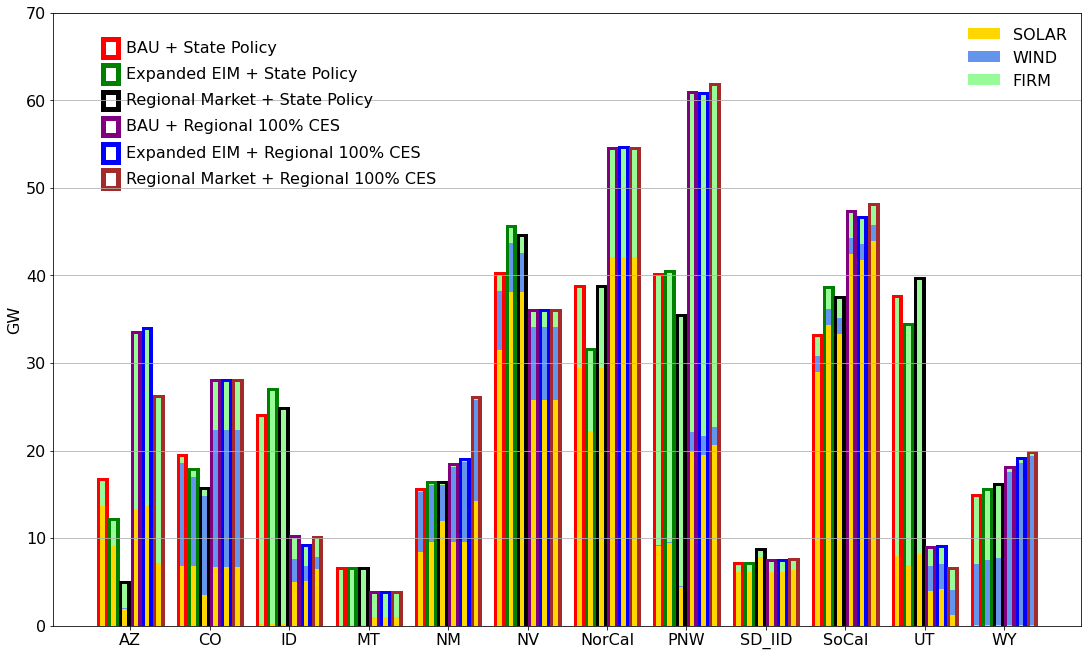

In [26]:
ind = np.arange(len(aggregated_cap))

fig, ax = plt.subplots(1, 1, figsize = (fig1, fig2), constrained_layout = True)

bar_width = 0.06
bar_space = 0.14
linew = 7

for x in range(0, len(aggregated_cap_scenario)):
    
    ax.bar(ind + bar_space * x, aggregated_cap_scenario[x].SOLAR + aggregated_cap_scenario[x].WIND + aggregated_cap_scenario[x].BIOPOWER + 
                                aggregated_cap_scenario[x].NONCCS_COAL + 
                                aggregated_cap_scenario[x].CCS_COAL + aggregated_cap_scenario[x].GEOTHERMAL + 
                                aggregated_cap_scenario[x].NONCCS_GAS + aggregated_cap_scenario[x].CCS_GAS +
                                aggregated_cap_scenario[x].HYDRO + aggregated_cap_scenario[x].NUCLEAR +
                                aggregated_cap_scenario[x].OTHER, 
           width = bar_width, label = '', color = 'white', edgecolor = color_scenarios[x], 
           linewidth = linew)
    string_label = 'SOLAR' if x == 0 else ''
    ax.bar(ind + bar_space * x, aggregated_cap_scenario[x].SOLAR, width = bar_width, label = string_label, 
           color = 'gold')
    string_label = 'WIND' if x == 0 else ''
    ax.bar(ind + bar_space * x, aggregated_cap_scenario[x].WIND, width = bar_width, label = string_label, 
           color = 'cornflowerblue', bottom = aggregated_cap_scenario[x].SOLAR)
    string_label = 'FIRM' if x == 0 else ''
    ax.bar(ind + bar_space * x, aggregated_cap_scenario[x].BIOPOWER + aggregated_cap_scenario[x].NONCCS_COAL + 
                                aggregated_cap_scenario[x].CCS_COAL + aggregated_cap_scenario[x].GEOTHERMAL + 
                                aggregated_cap_scenario[x].NONCCS_GAS + aggregated_cap_scenario[x].CCS_GAS +
                                aggregated_cap_scenario[x].HYDRO + aggregated_cap_scenario[x].NUCLEAR +
                                aggregated_cap_scenario[x].OTHER,
           width = bar_width, label = string_label, 
           color = 'palegreen', bottom = aggregated_cap_scenario[x].SOLAR + aggregated_cap_scenario[x].WIND)
    
ax.set_ylabel('GW', fontsize = fs)
ax.tick_params(axis = 'y', labelsize = fs)
ax.tick_params(axis = 'x', labelsize = fs)
ax.yaxis.grid()
ax.set_xticks(ind + 5 * bar_space / 2)
ax.set_xticklabels(aggregated_cap.index)
ax.legend(fontsize = fs, frameon = False)
# ax.set_ylim(0, ymax + 10)
ax.set_ylim(0, 70)

for x in range(0, len(aggregated_cap_scenario)):
    ax.add_patch(Rectangle((0, 65 - 3 * x), 0.2, 2, fc = 'none', ec = color_scenarios[x], lw = 5))
    ax.text(0.3, 65.5 - 3 * x, scenario_names[x], fontsize = fs)

plt.savefig(os.path.join(resultpath, "Regionalization paper", "solar_wind_scenarios.pdf"), dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### All other capacities in scenarios

In [38]:
ymax = 0
for x in enumerate(scenario_names):
    if ymax < aggregated_cap_scenario[x[0]][['BIOPOWER', 'NONCCS_COAL', 'CCS_COAL', 'GEOTHERMAL', 'NONCCS_GAS', 'CCS_GAS', 'HYDRO', 'NUCLEAR', 'OTHER']].sum(axis=1).max():
        ymax = aggregated_cap_scenario[x[0]][['BIOPOWER', 'NONCCS_COAL', 'CCS_COAL', 'GEOTHERMAL', 'NONCCS_GAS', 'CCS_GAS', 'HYDRO', 'NUCLEAR', 'OTHER']].sum(axis=1).max()

In [ ]:
ind = np.arange(len(aggregated_cap))

fig, ax = plt.subplots(1, 1, figsize = (fig1, fig2), constrained_layout = True)

bar_width = 0.09
bar_space = 0.155
linew = 5
color_scenarios = ['red', 'green', 'black', 'purple', 'blue', 'brown']

for x in range(0, len(aggregated_cap_scenario)):

    ax.bar(ind + bar_space * x, aggregated_cap_scenario[x].BIOPOWER + aggregated_cap_scenario[x].NONCCS_COAL + 
                                aggregated_cap_scenario[x].CCS_COAL + aggregated_cap_scenario[x].GEOTHERMAL + 
                                aggregated_cap_scenario[x].NONCCS_GAS + aggregated_cap_scenario[x].CCS_GAS +
                                aggregated_cap_scenario[x].HYDRO + aggregated_cap_scenario[x].NUCLEAR +
                                aggregated_cap_scenario[x].OTHER, width = bar_width, label = '', 
           color = 'white', edgecolor = color_scenarios[x], linewidth = linew)
    
    string_label = 'BIOPOWER' if x == 0 else ''
    ax.bar(ind + bar_space * x, aggregated_cap_scenario[x].BIOPOWER, width = bar_width, label = string_label, 
           color = 'dimgray')
    
    string_label = 'NON CCS COAL' if x == 0 else ''
    ax.bar(ind + bar_space * x, aggregated_cap_scenario[x].NONCCS_COAL, width = bar_width, label = string_label, 
           color = 'darkviolet', bottom = aggregated_cap_scenario[x].BIOPOWER)

    string_label = 'CCS COAL' if x == 0 else ''
    ax.bar(ind + bar_space * x, aggregated_cap_scenario[x].CCS_COAL, width = bar_width, label = string_label, 
           color = 'orange', bottom = aggregated_cap_scenario[x].BIOPOWER + 
           aggregated_cap_scenario[x].NONCCS_COAL)
    
    string_label = 'GEOTHERMAL' if x == 0 else ''
    ax.bar(ind + bar_space * x, aggregated_cap_scenario[x].GEOTHERMAL, width = bar_width, label = string_label, 
           color = 'lawngreen', bottom = aggregated_cap_scenario[x].BIOPOWER + 
           aggregated_cap_scenario[x].NONCCS_COAL + aggregated_cap_scenario[x].CCS_COAL)
    
    string_label = 'NON CCS GAS' if x == 0 else ''
    ax.bar(ind + bar_space * x, aggregated_cap_scenario[x].NONCCS_GAS, width = bar_width, label = string_label, 
           color = 'orangered', bottom = aggregated_cap_scenario[x].BIOPOWER + 
           aggregated_cap_scenario[x].NONCCS_COAL + aggregated_cap_scenario[x].CCS_COAL + 
           aggregated_cap_scenario[x].GEOTHERMAL)
    
    string_label = 'CCS GAS' if x == 0 else ''
    ax.bar(ind + bar_space * x, aggregated_cap_scenario[x].CCS_GAS, width = bar_width, label = string_label, 
           color = 'firebrick', bottom = aggregated_cap_scenario[x].BIOPOWER + 
           aggregated_cap_scenario[x].NONCCS_COAL + aggregated_cap_scenario[x].CCS_COAL + 
           aggregated_cap_scenario[x].GEOTHERMAL + aggregated_cap_scenario[x].NONCCS_GAS)
    
    string_label = 'HYDRO' if x == 0 else ''
    ax.bar(ind + bar_space * x, aggregated_cap_scenario[x].HYDRO, width = bar_width, label = string_label, 
           color = 'royalblue', bottom = aggregated_cap_scenario[x].BIOPOWER + 
           aggregated_cap_scenario[x].NONCCS_COAL + aggregated_cap_scenario[x].CCS_COAL + 
           aggregated_cap_scenario[x].GEOTHERMAL + aggregated_cap_scenario[x].NONCCS_GAS + 
           aggregated_cap_scenario[x].CCS_GAS)
    
    string_label = 'NUCLEAR' if x == 0 else ''
    ax.bar(ind + bar_space * x, aggregated_cap_scenario[x].NUCLEAR, width = bar_width, label = string_label, 
           color = 'darkslategray', bottom = aggregated_cap_scenario[x].BIOPOWER + 
           aggregated_cap_scenario[x].NONCCS_COAL + aggregated_cap_scenario[x].CCS_COAL + 
           aggregated_cap_scenario[x].GEOTHERMAL + aggregated_cap_scenario[x].NONCCS_GAS + 
           aggregated_cap_scenario[x].CCS_GAS + aggregated_cap_scenario[x].HYDRO)
    
    string_label = 'OTHER' if x == 0 else ''
    ax.bar(ind + bar_space * x, aggregated_cap_scenario[x].OTHER, width = bar_width, label = string_label, 
           color = 'magenta', bottom = aggregated_cap_scenario[x].BIOPOWER + 
           aggregated_cap_scenario[x].NONCCS_COAL + aggregated_cap_scenario[x].CCS_COAL + 
           aggregated_cap_scenario[x].GEOTHERMAL + aggregated_cap_scenario[x].NONCCS_GAS + 
           aggregated_cap_scenario[x].CCS_GAS + aggregated_cap_scenario[x].HYDRO + 
           aggregated_cap_scenario[x].NUCLEAR)
    
ax.set_ylabel('GW', fontsize = fs)
ax.tick_params(axis = 'y', labelsize = fs)
ax.tick_params(axis = 'x', labelsize = fs)
ax.yaxis.grid()
ax.set_xticks(ind + 5 * bar_space / 2)
ax.set_xticklabels(aggregated_cap.index)
ax.legend(fontsize = fs, frameon = False)
ax.set_ylim(0, ymax + 5)

for x in range(0, len(aggregated_cap_scenario)):
    ax.add_patch(Rectangle((0, 38 - 2 * x), 0.2, 1.3, fc = 'none', ec = color_scenarios[x], lw = 3))
    ax.text(0.3, 38.3 - 2 * x, scenario_names[x], fontsize = fs)

plt.savefig(os.path.join(resultpath, "Regionalization paper", "all_other_scenarios.pdf"), dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### Minimum of solar, wind, and storage in scenarios

In [27]:
minimum_df = pd.DataFrame()
for x in enumerate(['STOR', 'SOLAR', 'WIND']):
    temp_df = pd.DataFrame()
    for y in range(0,len(scenario_names)):
        temp_df[y] = aggregated_cap_scenario[y][x[1]]
        
    minimum_df[x[1]] = temp_df.min(axis = 1)
    
clean_scenarios = [idx for idx, s in enumerate(scenario_names) if '100% CES' in s]

minimum_df_ces = pd.DataFrame()
for x in enumerate(['STOR', 'SOLAR', 'WIND']):
    temp_df = pd.DataFrame()
    for y in clean_scenarios:
        temp_df[y] = aggregated_cap_scenario[y][x[1]]
        
    minimum_df_ces[x[1]] = temp_df.min(axis = 1)

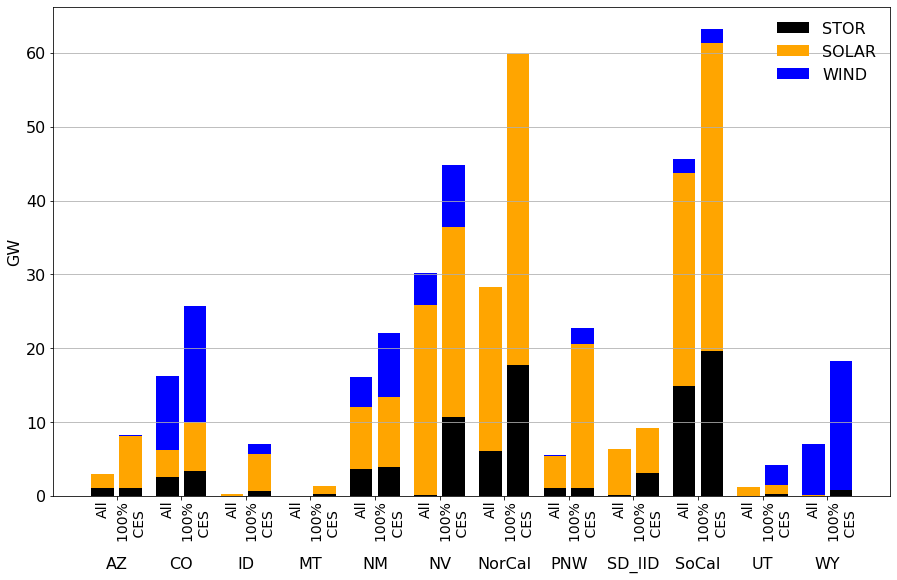

In [28]:
ind = np.arange(len(minimum_df.index))
bar_width = 0.35
bar_space = 0.43
linew = 7

fig, ax = plt.subplots(1, 1, figsize = (fig1, fig2))

# ax.bar(ind, minimum_df.STOR + minimum_df.SOLAR + minimum_df.WIND, width = bar_width, label = '', 
#        color = 'white', edgecolor = 'red', linewidth = linew)

ax.bar(ind, minimum_df.STOR, width = bar_width, label = 'STOR', color = 'black')
ax.bar(ind, minimum_df.SOLAR, width = bar_width, label = 'SOLAR', color = 'orange', bottom = minimum_df.STOR)
ax.bar(ind, minimum_df.WIND, width = bar_width, label = 'WIND', color = 'blue', bottom = minimum_df.STOR + 
       minimum_df.SOLAR)

# ax.bar(ind + bar_space, minimum_df_ces.STOR + minimum_df_ces.SOLAR + minimum_df_ces.WIND, width = bar_width, 
#        color = 'white', edgecolor = 'green', linewidth = linew)

ax.bar(ind + bar_space, minimum_df_ces.STOR, width = bar_width, color = 'black')
ax.bar(ind + bar_space, minimum_df_ces.SOLAR, width = bar_width, color = 'orange', bottom = minimum_df_ces.STOR)
ax.bar(ind + bar_space, minimum_df_ces.WIND, width = bar_width, color = 'blue', 
       bottom = minimum_df_ces.STOR + minimum_df_ces.SOLAR)

ax.set_ylabel('GW', fontsize = fs)
ax.tick_params(axis = 'y', labelsize = fs)
ax.tick_params(axis = 'x', labelsize = fs)
ax.yaxis.grid()
ax.set_xticks(ind + bar_space / 2)
ax.set_xticklabels(minimum_df.index)
ax.legend(fontsize = fs, frameon = False)
ax.set_ylim(0, max(max(minimum_df.STOR + minimum_df.SOLAR + minimum_df.WIND), 
                   max(minimum_df_ces.STOR + minimum_df_ces.SOLAR + minimum_df_ces.WIND)) + 3)

ax.tick_params(axis = 'x', which = 'major', pad = 57)

# ax.add_patch(Rectangle((0, 56), 0.3, 3, fc = 'none', ec = 'red', lw = 5))
# ax.add_patch(Rectangle((0, 52), 0.3, 3, fc = 'none', ec = 'green', lw = 5))
# ax.text(0.5, 56.7, 'Across all scenarios', fontsize = fs)
# ax.text(0.5, 52.7, 'Across Regional 100% CES scenarios', fontsize = fs)

for indnumber in ind - 0.1:
    ax.text(indnumber, -2.5, 'All', fontsize = 14, rotation = 90)
for indnumber in ind + 0.22:
    ax.text(indnumber, -5.8, '100% \n CES', fontsize = 14, rotation = 90)
    
plt.savefig(os.path.join(resultpath, "Regionalization paper", "minimum.pdf"), dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### Aggregated transmission capacities in scenarios

In [20]:
existing_network = network[['transmission_path_name', 'Line_Max_Flow_MW']]
existing_network = existing_network.rename(columns = {'Line_Max_Flow_MW':'Existing'})

In [21]:
existing_cap = sum(network.Line_Max_Flow_MW) / 1000
# proposed_cap = sum(pronetwork.Line_Max_Flow_MW) / 1000

In [22]:
upgrade_cap = []
for x in enumerate(scenario_names):
    tempdf = existing_network.rename(columns = {'transmission_path_name':'Path'})
    tempdf = tempdf.set_index('Path')
    tempdf = tempdf / 1000
    tempdf = pd.merge(tempdf, totalline_cap_scenario[x[0]], how = 'outer', on = 'Path')
#     tempdf['Upgrade'] = tempdf.OptValues - tempdf.Existing
#     upgrade_cap.append(sum(tempdf['Upgrade']))
    tempdf['Expansion'] = tempdf.OptValues - tempdf.Existing
    upgrade_cap.append(sum(tempdf['Expansion']))

In [23]:
transmission_df = pd.DataFrame()
transmission_df['Existing'] = [existing_cap] * len(scenario_names)
# transmission_df['Proposed'] = [proposed_cap] * len(scenario_names)
# transmission_df['Upgrade'] = upgrade_cap
transmission_df['Expansion'] = upgrade_cap
# transmission_df['New Line'] = newline_cap
transmission_df.index = scenario_names

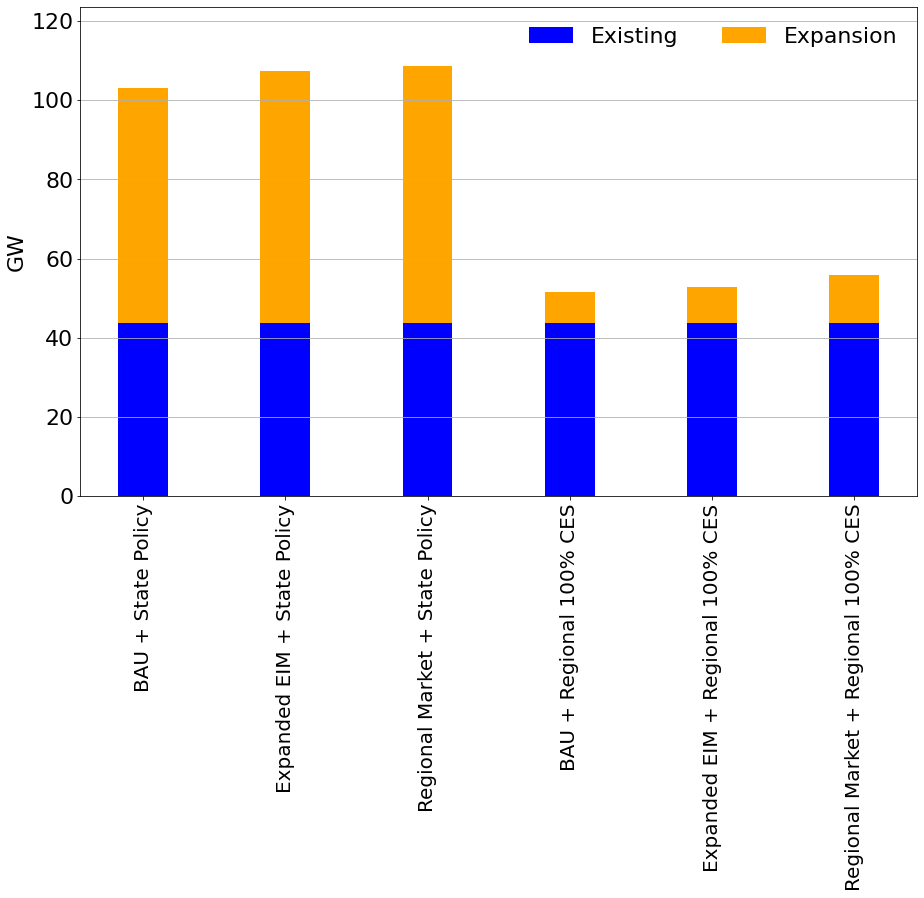

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (fig1, fig2))
ax.bar(transmission_df.index, transmission_df.Existing, width = bar_width, label = 'Existing', color = 'blue')
# ax.bar(transmission_df.index, transmission_df.Proposed, width = bar_width, label = 'Proposed', color = 'orange', 
#        bottom = transmission_df.Existing)
# ax.bar(transmission_df.index, transmission_df.Upgrade, width = bar_width, label = 'Upgrade', color = 'green', 
#        bottom = transmission_df.Existing + transmission_df.Proposed)
ax.bar(transmission_df.index, transmission_df.Expansion, width = bar_width, label = 'Expansion', color = 'orange', 
       bottom = transmission_df.Existing)
# ax.bar(storage_df.index, storage_df['New Line'], width = bar_width, label = 'New Line', color = 'red', 
#        bottom = storage_df.Existing + storage_df.Proposed + storage_df.Upgrade)

ax.set_ylabel('GW', fontsize = 22)
ax.tick_params(axis = 'y', labelsize = 22)
ax.tick_params(axis = 'x', labelsize = 20, rotation = 90)
# ax.set_ylim(0, 
#             max(transmission_df.Existing + transmission_df.Proposed + transmission_df.Upgrade + storage_df['New Line']) + 15)
ax.set_ylim(0, 
            max(transmission_df.Existing + transmission_df.Expansion) + 15)
ax.yaxis.grid()
ax.legend(fontsize = 22, frameon = False, ncol = 3)
plt.savefig(os.path.join(resultpath, "Regionalization paper", "transmission_scenarios.pdf"), dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### MW-mile of transmission lines in scenarios

In [34]:
existing_gwmile = sum(network.Line_Max_Flow_MW / 1000 * network.distance_mile)
# proposed_gwmile = sum(pronetwork.Line_Max_Flow_MW / 1000 * pronetwork.distance_mile)

In [35]:
existing_mile = network[['transmission_path_name', 'distance_mile']]
existing_mile = existing_mile.rename(columns = {'transmission_path_name':'Path'})

In [36]:
upgrade_gwmile = []
for x in enumerate(scenario_names):
    tempdf = existing_network.rename(columns = {'transmission_path_name':'Path'})
    tempdf = tempdf.set_index('Path')
    tempdf = tempdf / 1000
    tempdf = pd.merge(tempdf, totalline_cap_scenario[x[0]], how = 'outer', on = 'Path')
#     tempdf['Upgrade'] = tempdf.OptValues - tempdf.Existing
    tempdf['Expansion'] = tempdf.OptValues - tempdf.Existing
    tempdf = pd.merge(tempdf, existing_mile, how = 'outer', on = 'Path')
#     upgrade_gwmile.append(sum(tempdf['Upgrade'] * tempdf['distance_mile']))
    upgrade_gwmile.append(sum(tempdf['Expansion'] * tempdf['distance_mile']))

In [37]:
gwmile_df = pd.DataFrame()
gwmile_df['Existing'] = [existing_gwmile] * len(scenario_names)
# gwmile_df['Proposed'] = [proposed_gwmile] * len(scenario_names)
# gwmile_df['Upgrade'] = upgrade_gwmile
gwmile_df['Expansion'] = upgrade_gwmile
# gwmile_df['New Line'] = newline_gwmile
gwmile_df.index = scenario_names

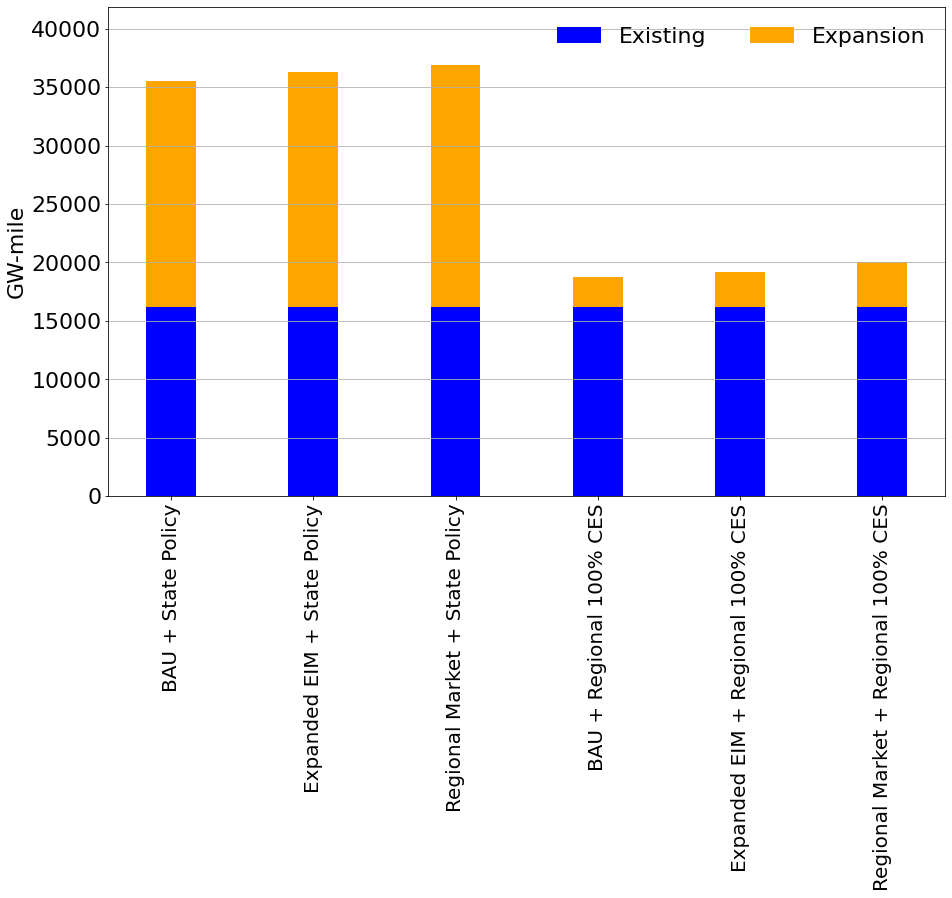

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (fig1, fig2))
ax.bar(gwmile_df.index, gwmile_df.Existing, width = bar_width, label = 'Existing', color = 'blue')
# ax.bar(gwmile_df.index, gwmile_df.Proposed, width = bar_width, label = 'Proposed', color = 'orange', 
#        bottom = gwmile_df.Existing)
# ax.bar(gwmile_df.index, gwmile_df.Upgrade, width = bar_width, label = 'Upgrade', color = 'green', 
#        bottom = gwmile_df.Existing + gwmile_df.Proposed)
ax.bar(gwmile_df.index, gwmile_df.Expansion, width = bar_width, label = 'Expansion', color = 'orange', 
       bottom = gwmile_df.Existing)
# ax.bar(gwmile_df.index, gwmile_df['New Line'], width = bar_width, label = 'New Line', color = 'red', 
#        bottom = gwmile_df.Existing + gwmile_df.Proposed + gwmile_df.Upgrade)

ax.set_ylabel('GW-mile', fontsize = 22)
ax.tick_params(axis = 'y', labelsize = 22)
ax.tick_params(axis = 'x', labelsize = 20, rotation = 90)
# ax.set_ylim(0, 
#             max(gwmile_df.Existing + gwmile_df.Proposed + gwmile_df.Upgrade + gwmile_df['New Line']) + 9000)
ax.set_ylim(0, 
            max(gwmile_df.Existing + gwmile_df.Expansion) + 5000)
ax.yaxis.grid()
ax.legend(fontsize = 22, frameon = False, ncol = 3)
plt.savefig(os.path.join(resultpath, "Regionalization paper", "gwmile.pdf"), dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### Storage existing and new build capacities in scenarios

In [12]:
storage_cap = pd.DataFrame()

In [13]:
existing_cap = []
newbuild_cap= []
for x in enumerate(scenario_names):
    existing_stor = sum(allcap_scenario[x[0]][allcap_scenario[x[0]]['Resource'].str.contains('batteries') |
                        allcap_scenario[x[0]]['Resource'].str.contains('hydroelectric_pumped_storage') |
                        allcap_scenario[x[0]]['Resource'].str.contains('solar_thermal_with_energy_storage')].OptValues)
    newbuild_stor = sum(allcap_scenario[x[0]][allcap_scenario[x[0]]['Resource'].str.contains('battery') |
                        allcap_scenario[x[0]]['Resource'].str.contains('newpumped')].OptValues)
    existing_cap.append(existing_stor)
    newbuild_cap.append(newbuild_stor)

In [14]:
storage_cap['Existing'] = existing_cap
storage_cap['New Build'] = newbuild_cap
storage_cap['Existing GWh'] = [45.24261, 45.24261, 45.24261, 45.24261, 45.24261, 45.24261] # HARD-CODED
# storage_cap['New Build GWh'] = [135.49749, 124.94527, 117.70795, 395.84634, 385.33797, 385.86646]
storage_cap['New Build GWh'] = [162.9725262, 153.2300404, 141.6196618, 395.84634, 385.33797, 385.86646] # HARD-CODED
storage_cap.index = scenario_names

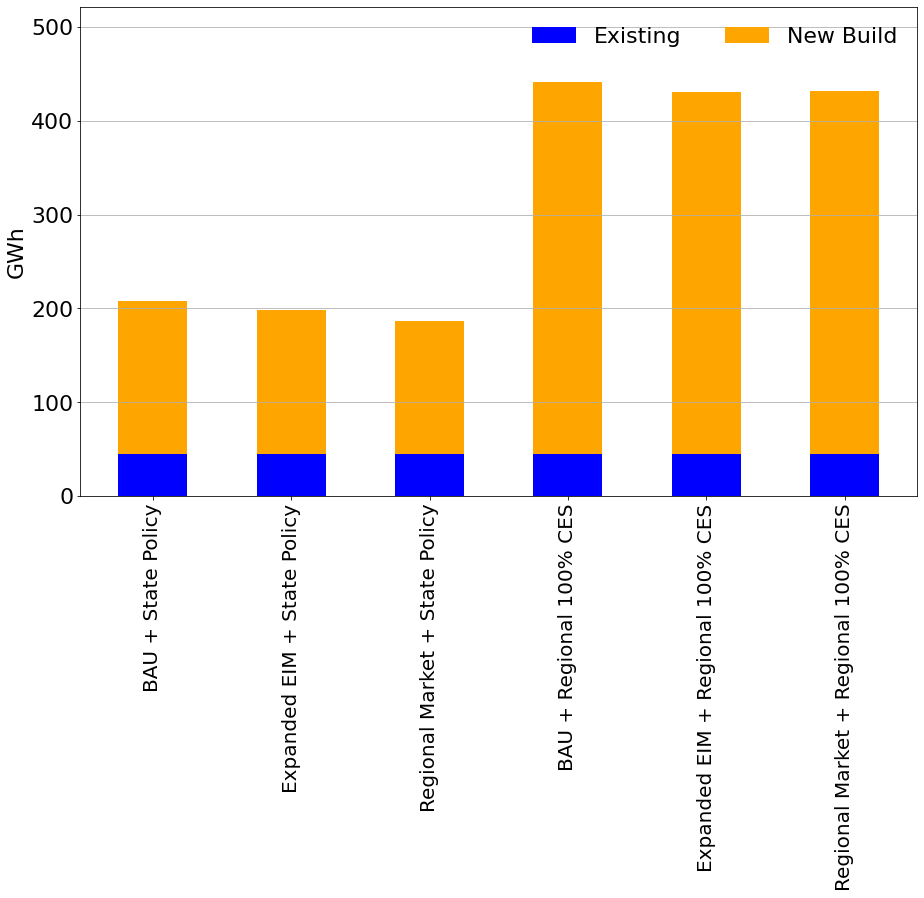

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (fig1, fig2))
# ax.bar(storage_cap.index, storage_cap.Existing, width = bar_width, label = 'Existing', color = 'blue')
# ax.bar(storage_cap.index, storage_cap['New Build'], width = bar_width, label = 'New Build', color = 'orange', 
#        bottom = storage_cap.Existing)
ax.bar(storage_cap.index, storage_cap['Existing GWh'], width = bar_width, label = 'Existing', color = 'blue')
ax.bar(storage_cap.index, storage_cap['New Build GWh'], width = bar_width, label = 'New Build', color = 'orange', 
       bottom = storage_cap['Existing GWh'])

# ax.set_ylabel('GW', fontsize = 22)
ax.set_ylabel('GWh', fontsize = 22)
ax.tick_params(axis = 'y', labelsize = 22)
ax.tick_params(axis = 'x', labelsize = 20, rotation = 90)
# ax.set_ylim(0, max(storage_cap.Existing + storage_cap['New Build']) + 20)
ax.set_ylim(0, max(storage_cap['Existing GWh'] + storage_cap['New Build GWh']) + 80)
ax.yaxis.grid()
ax.legend(fontsize = 22, frameon = False, ncol = 2)
plt.savefig(os.path.join(resultpath, "Regionalization paper", "storage_scenarios.pdf"), dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### Paths in scenarios

In [43]:
total_expansion = pd.DataFrame()
for x in enumerate(scenario_names):
    tempdf = existing_network.rename(columns = {'transmission_path_name':'Path'})
    tempdf = tempdf.set_index('Path')
    tempdf = tempdf / 1000
    tempdf = pd.merge(tempdf, totalline_cap_scenario[x[0]], how = 'outer', on = 'Path')
#     tempdf['Upgrade'] = tempdf.OptValues - tempdf.Existing
    tempdf['Expansion'] = tempdf.OptValues - tempdf.Existing
    
    if x[0] == 0:
#         total_expansion[x[1]] = tempdf['Upgrade']
        total_expansion[x[1]] = tempdf['Expansion']
    else:
#         total_expansion = pd.merge(total_expansion, tempdf['Upgrade'], how = 'outer', on = 'Path')
        total_expansion = pd.merge(total_expansion, tempdf['Expansion'], how = 'outer', on = 'Path')
        
total_expansion.columns = scenario_names
total_expansion = total_expansion.loc[(total_expansion != 0).any(axis = 1)]

/var/folders/qy/hmk2jwb57sqfgmzwxnjr6f5h0000gn/T/ipykernel_45186/3673973556.py:15: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Expansion_x'} in the result is deprecated and will raise a MergeError in a future version.
  total_expansion = pd.merge(total_expansion, tempdf['Expansion'], how = 'outer', on = 'Path')


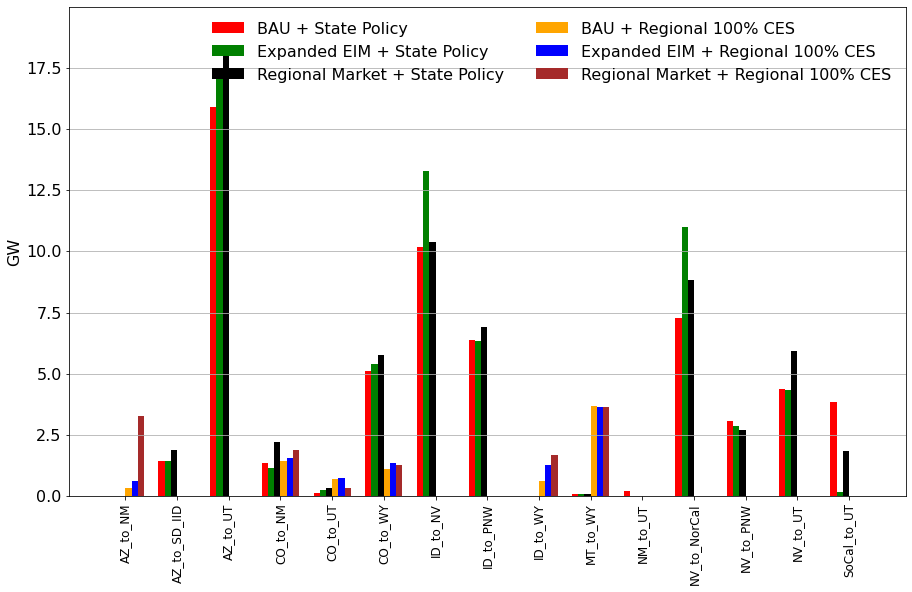

In [44]:
bar_space = 0.12
ind = np.arange(len(total_expansion))
color_scenarios = ['red', 'green', 'black', 'orange', 'blue', 'brown']

fig, ax = plt.subplots(1, 1, figsize = (fig1, fig2))

for index, x in enumerate(total_expansion):
    ax.bar(ind + bar_space * index, total_expansion[x], width = bar_space, label = x, 
           color = color_scenarios[index])
    
ax.set_ylabel('GW', fontsize = fs)
ax.tick_params(axis = 'y', labelsize = fs)
ax.tick_params(axis = 'x', labelsize = 12, rotation = 90)
ax.set_xticks(ind + 5 * bar_space / 2)
ax.set_xticklabels(total_expansion.index)
ax.set_ylim(0, total_expansion.max().max() + 2)
ax.yaxis.grid()
ax.legend(fontsize = fs, frameon = False, ncol = 2)
plt.savefig(os.path.join(resultpath, "Regionalization paper", "paths.pdf"), dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### Sensitivity

In [45]:
# marker_styles = ['o', '*', 's', 'D', '^']
marker_styles = ['o', '*', 's', 'D']

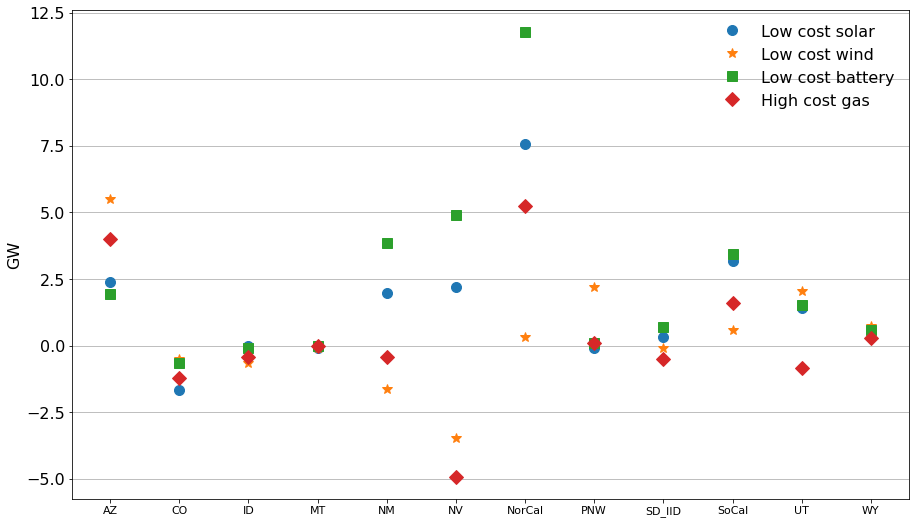

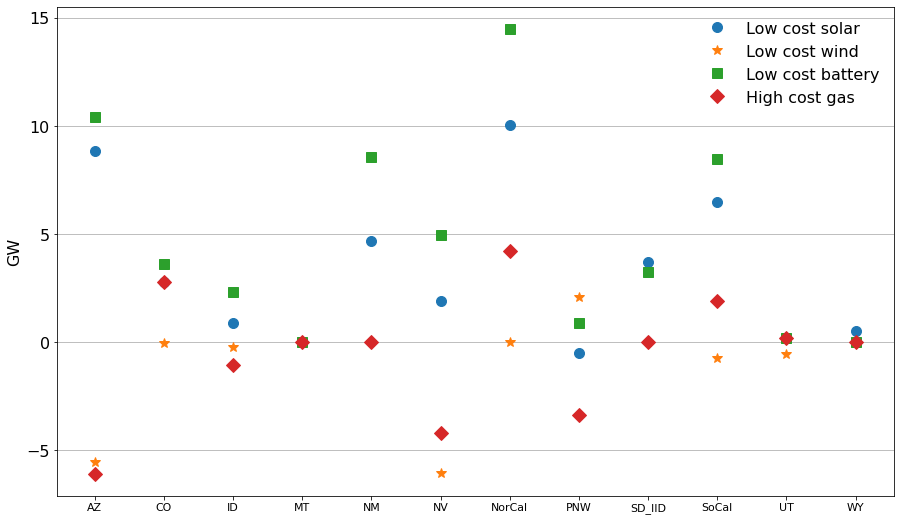

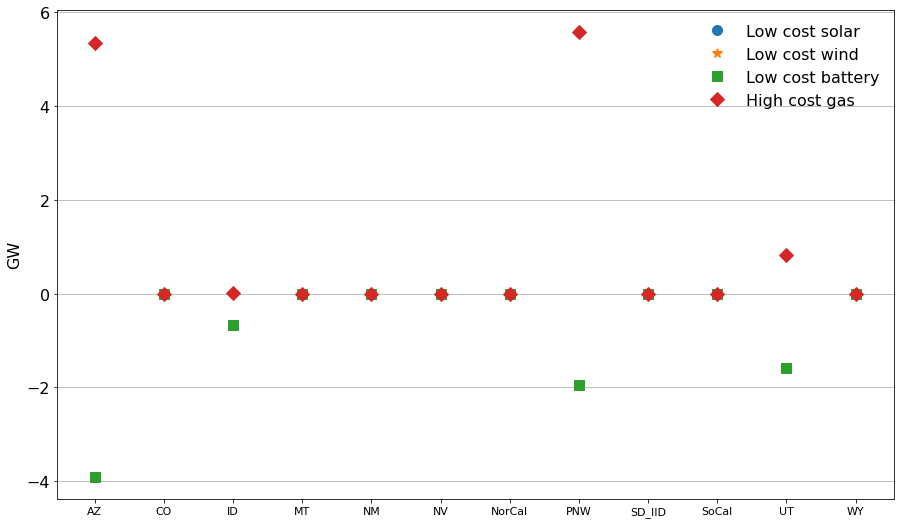

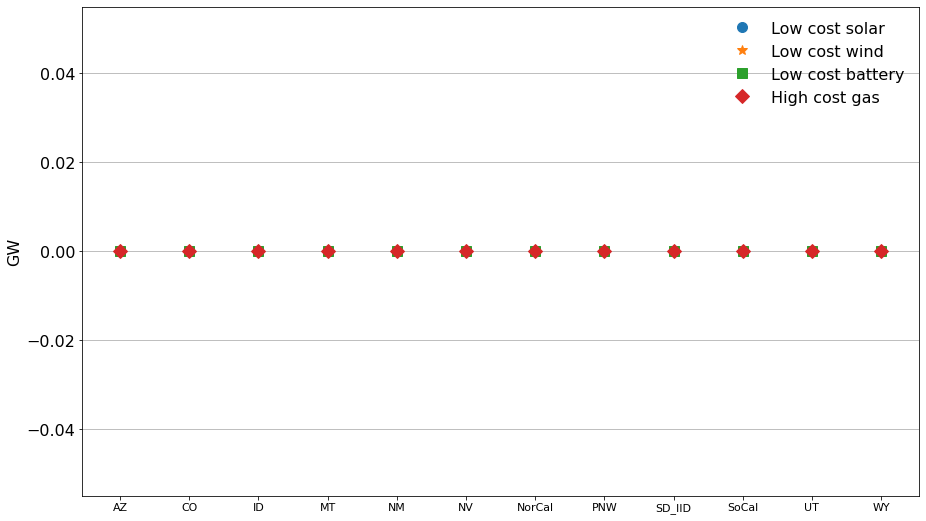

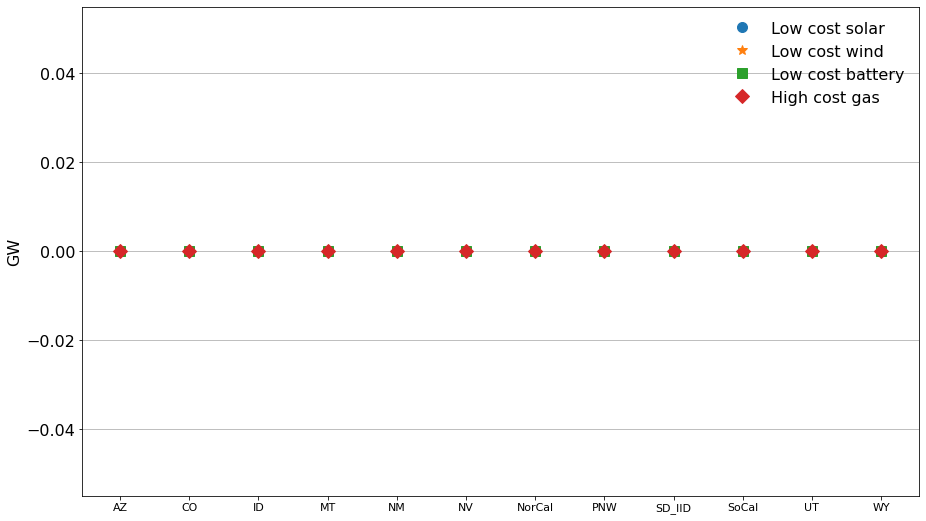

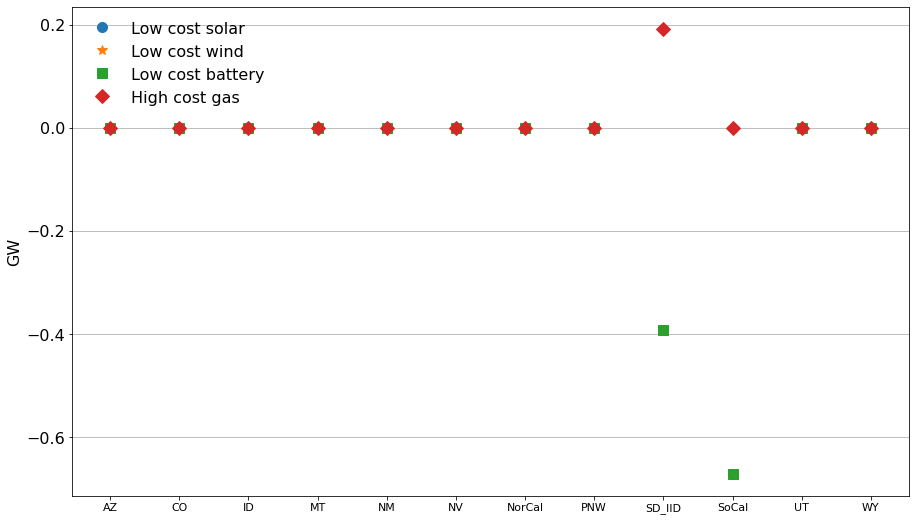

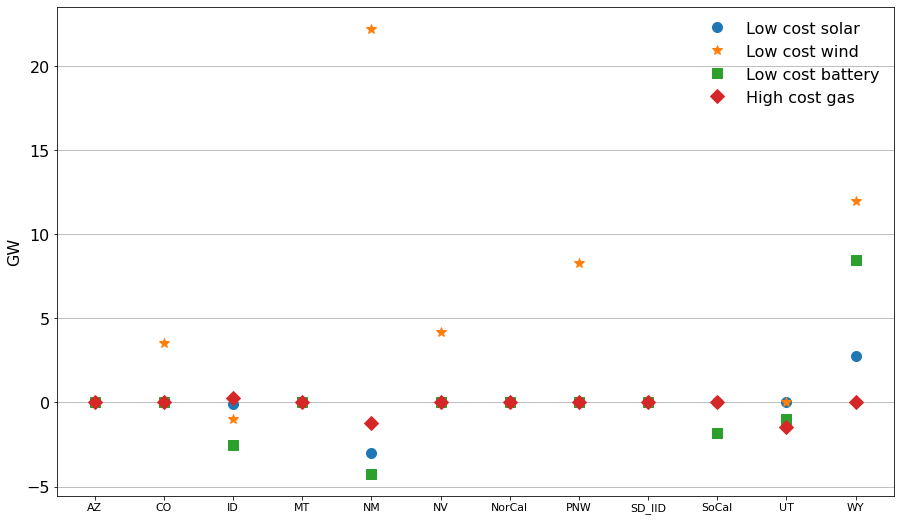

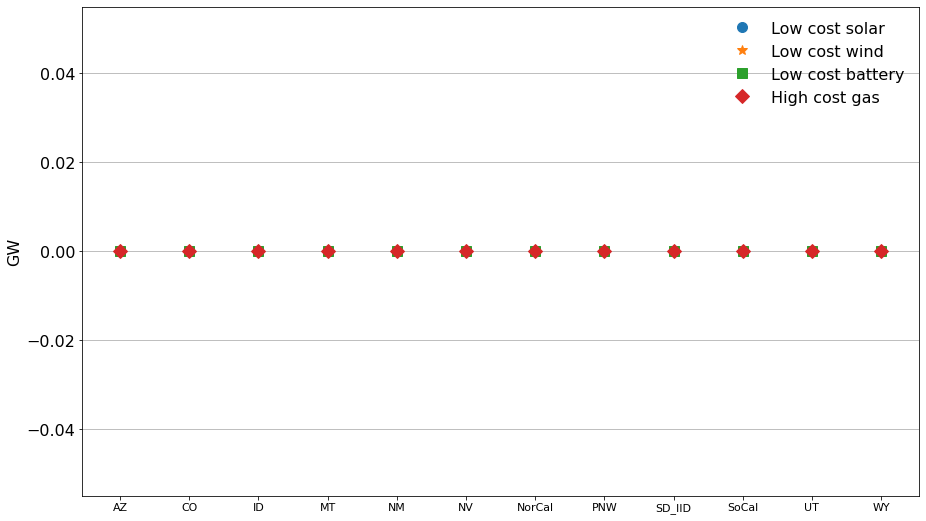

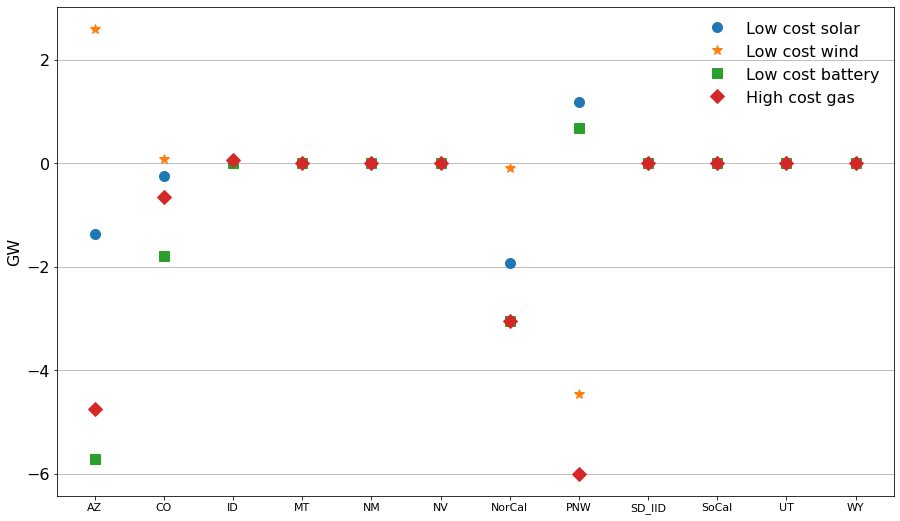

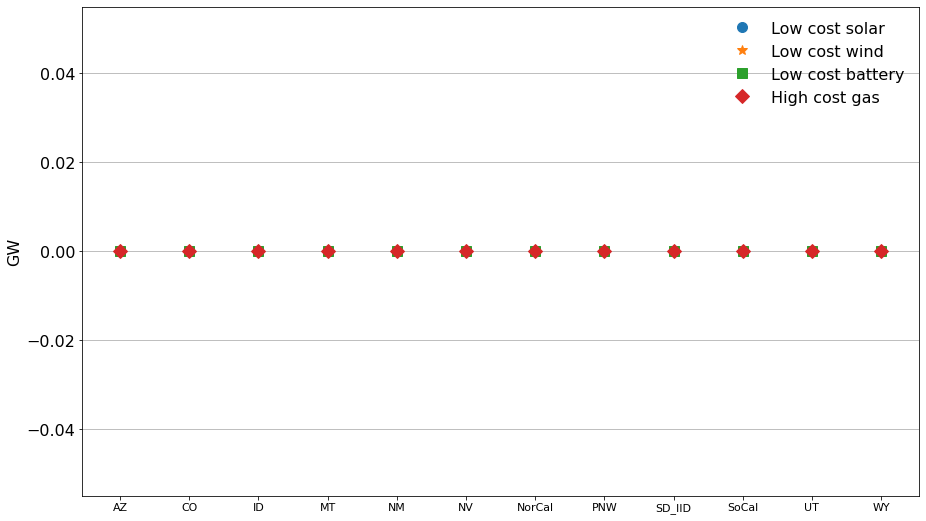

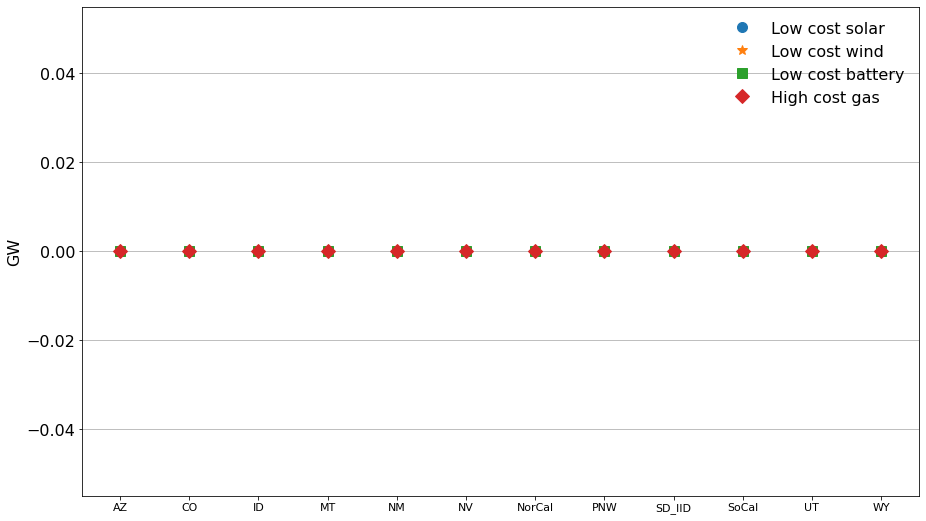

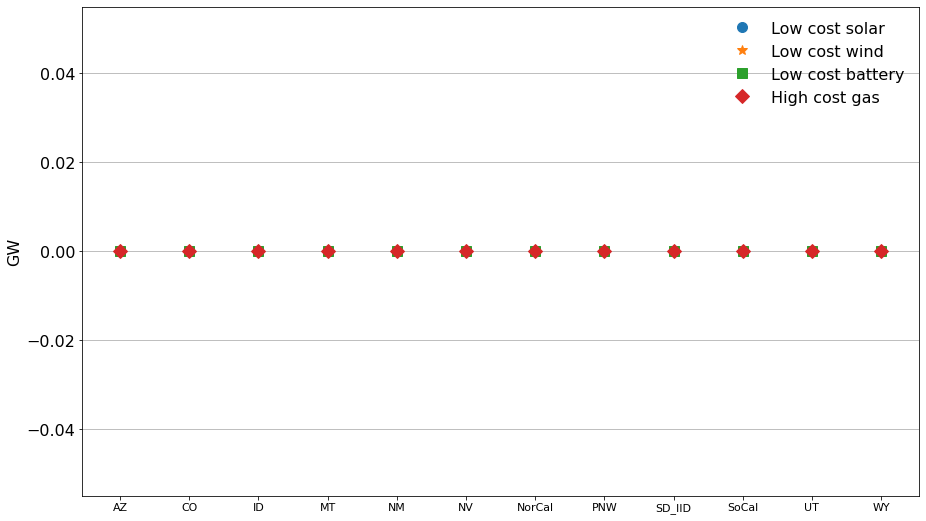

In [46]:
for res in aggregated_cap_3.columns:
    
    fig, ax = plt.subplots(1, 1, figsize = (fig1, fig2))
    
    for (index, data) in enumerate(aggregated_cap_sense):
        ax.plot(data[res] - aggregated_cap_3[res], 
                marker = marker_styles[index], markersize = 10, linestyle = "None", 
                label = resultsensefolders[index].split('/')[8])
    
    ax.set_ylabel('GW', fontsize = fs)
    ax.tick_params(axis = 'y', labelsize = fs)
    ax.tick_params(axis = 'x', labelsize = 11)
    ax.yaxis.grid()
    ax.legend(fontsize = fs, frameon = False)
    plt.savefig(os.path.join(resultpath, "Regionalization paper", res + "_sensitivity.pdf"), 
                dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

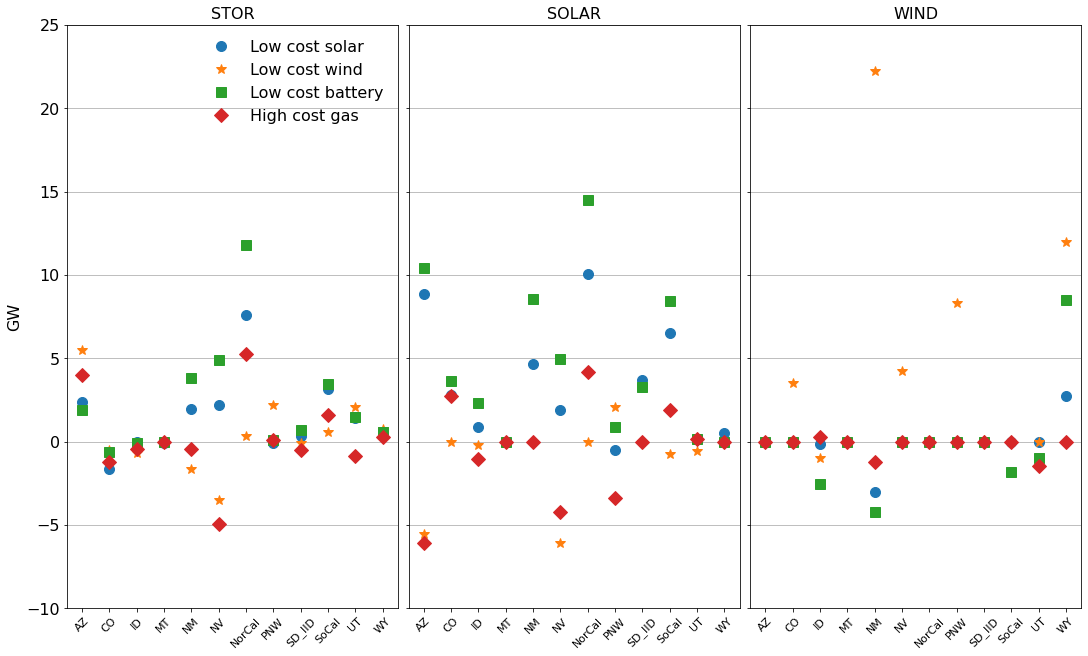

In [47]:
fig, ax = plt.subplots(1, 3, figsize = (fig1, fig2), constrained_layout = True)

for pnr, res in enumerate(['STOR', 'SOLAR', 'WIND']):
    
    for (index, data) in enumerate(aggregated_cap_sense):
        ax[pnr].plot(data[res] - aggregated_cap_3[res], 
                marker = marker_styles[index], markersize = 10, linestyle = "None", 
                label = resultsensefolders[index].split('/')[8])
    
    ax[pnr].tick_params(axis = 'x', labelsize = 11, rotation = 45)
    ax[pnr].yaxis.grid()
    ax[pnr].set_ylim(-10, 25)
    ax[pnr].set_title(res, fontsize = fs)
        
    if pnr == 0:
        ax[pnr].set_ylabel('GW', fontsize = fs)
        ax[pnr].tick_params(axis = 'y', labelsize = fs)
        ax[pnr].legend(fontsize = fs, frameon = False)
    else:
        ax[pnr].axes.yaxis.set_ticklabels([])

plt.savefig(os.path.join(resultpath, "Regionalization paper", "main_sensitivity.pdf"), 
                dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

/var/folders/qy/hmk2jwb57sqfgmzwxnjr6f5h0000gn/T/ipykernel_45186/1701229717.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(totalline_cap_3.index, rotation = 90)


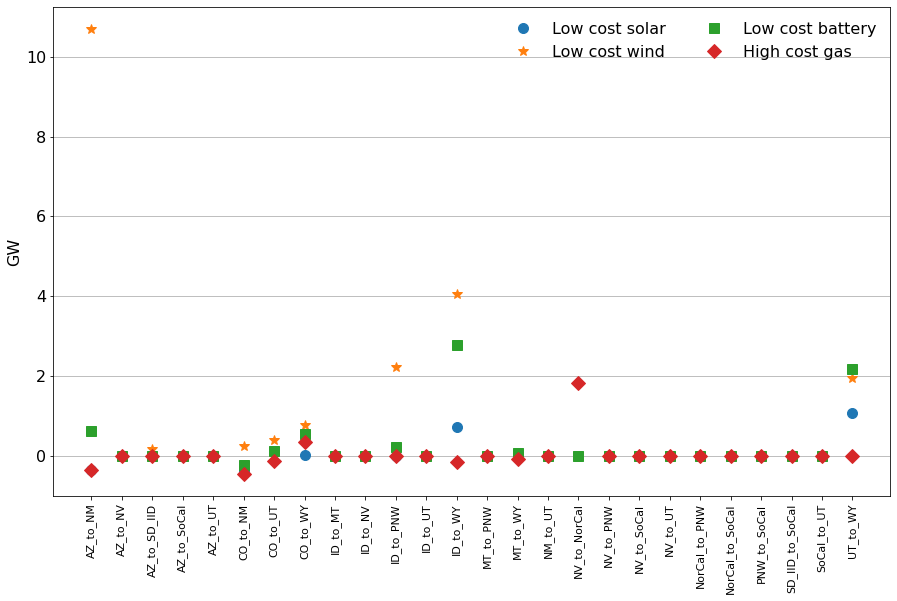

In [48]:
fig, ax = plt.subplots(1, 1, figsize = (fig1, fig2))
    
for (index, data) in enumerate(totalline_cap_sense):
    ax.plot(data['OptValues'] - totalline_cap_3['OptValues'], 
            marker = marker_styles[index], markersize = 10, linestyle = "None", 
            label = resultsensefolders[index].split('/')[8])

ax.set_ylabel('GW', fontsize = fs)
ax.tick_params(axis = 'y', labelsize = fs)
ax.tick_params(axis = 'x', labelsize = 11)
ax.yaxis.grid()
ax.legend(fontsize = fs, frameon = False, ncol = 2)
ax.set_xticklabels(totalline_cap_3.index, rotation = 90)
plt.savefig(os.path.join(resultpath, "Regionalization paper", "path_sensitivity.pdf"), 
            dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### Share in 100% CES + BAU scenario

In [55]:
dispatch = dispatch.fillna(0)
dispatch = dispatch.loc[:, dispatch.columns != 'STOR']
dispatch = dispatch.transpose()

new_header = dispatch.iloc[0]
dispatch = dispatch[1:]
dispatch.columns = new_header

dispatch = dispatch.div(dispatch.sum(axis = 0), axis = 1)

dispatch = dispatch.drop(['NONCCS_COAL', 'NONCCS_GAS'])

dispatch = dispatch * 100

In [56]:
centroid_proportions = pd.DataFrame(
                            {'AZ': [0.51, 0.18],
                             'CO': [0.72, 0.42],
                             'ID': [0.41, 0.68],
                             'MT': [0.53, 0.83],
                             'NM': [0.66, 0.18],
                             'NV': [0.34, 0.46],
                             'NorCal': [0.19, 0.44],
                             'PNW': [0.23, 0.73],
                             'SD_IID': [0.36, 0.1],
                             'SoCal': [0.32, 0.29],
                             'UT': [0.51, 0.44],
                             'WY': [0.65, 0.63]
                            }
)
centroid_proportions.index = ['Longitude', 'Latitude']

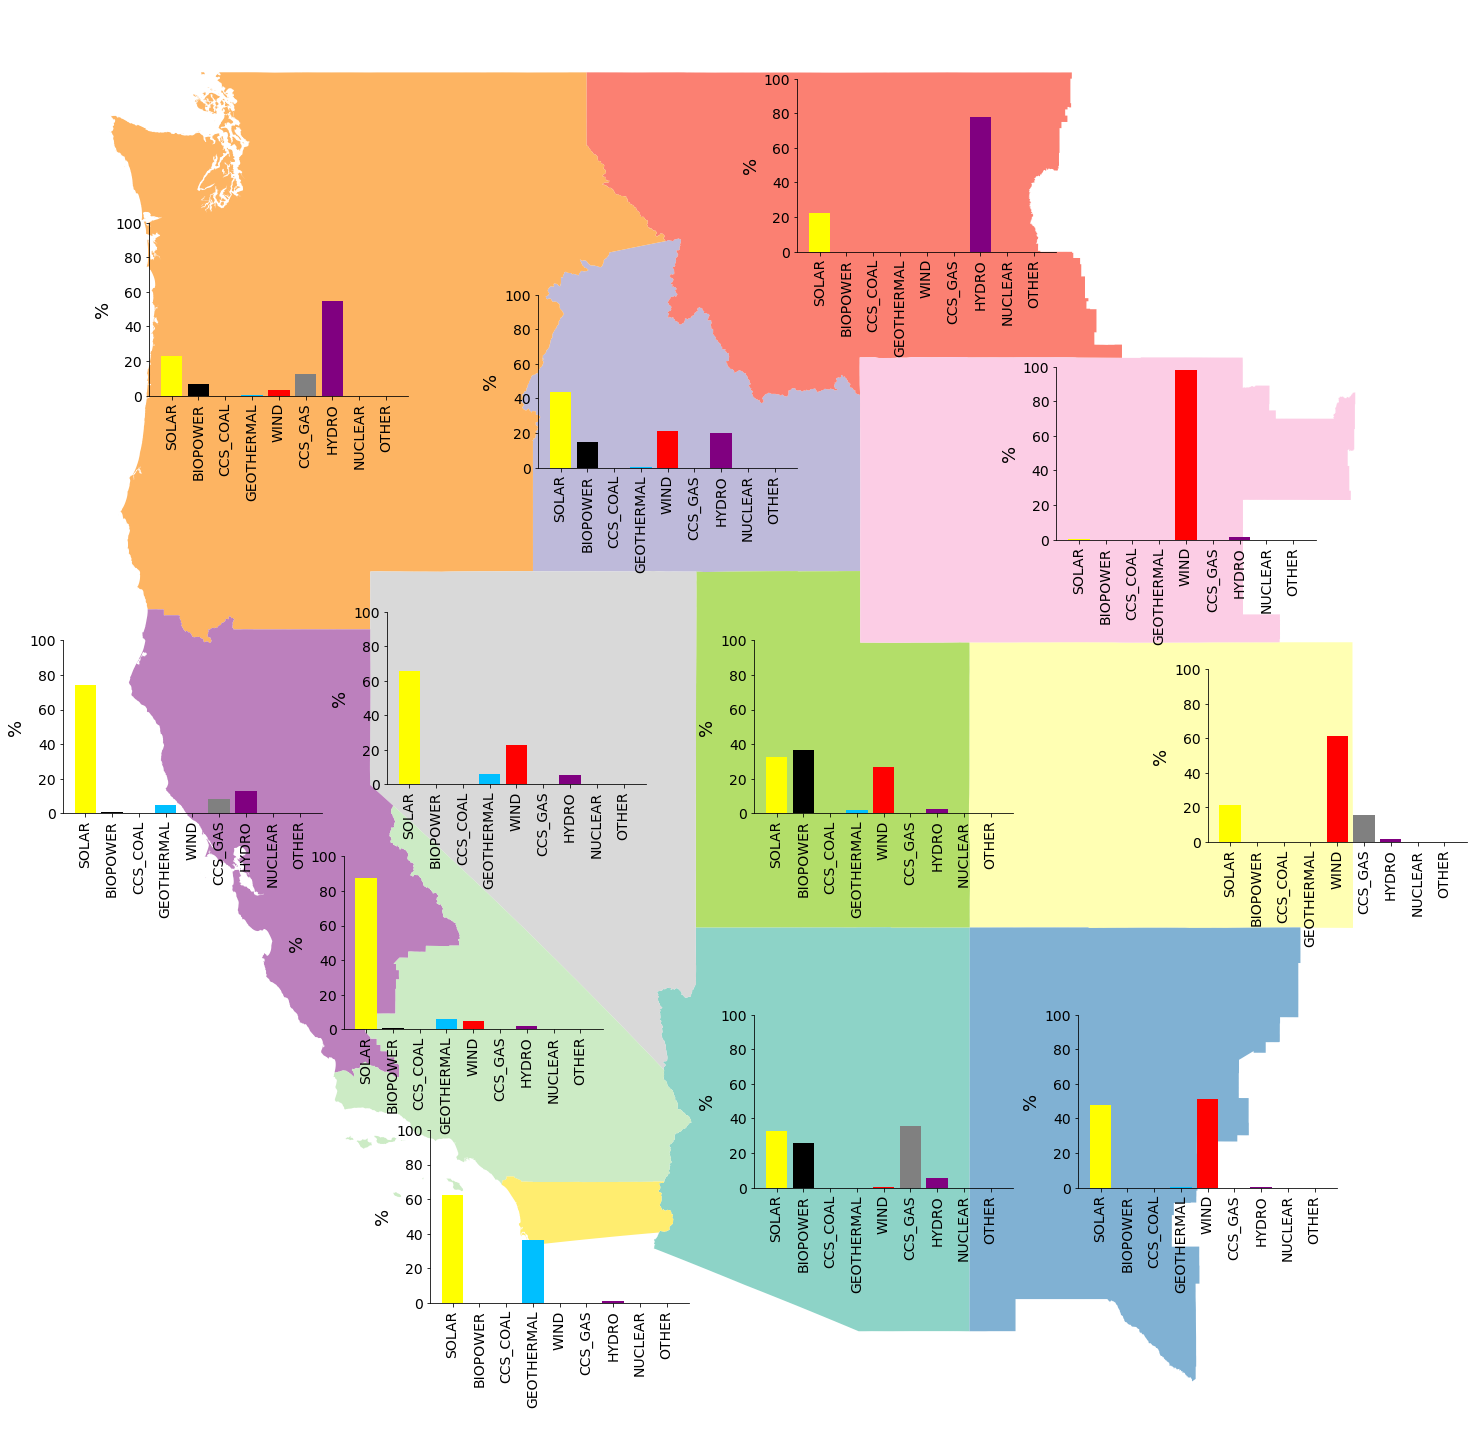

In [57]:
fs1, fs2 = 5, 5
fs3, fs4 = 0.12 * fs1, 0.12 * fs2

ind = np.arange(len(dispatch))
mycolors = ['yellow', 'black', 'green', 'deepskyblue', 'red', 'gray', 'purple', 
            'darkslategray', 'magenta']
mylabels = dispatch.index

fig = plt.figure()
ax_map = fig.add_axes([0, 0, fs1, fs2])
wecczone_shapes.plot(ax = ax_map, cmap = 'Set3')
ax_map.axis('off')

for (index, col) in enumerate(dispatch):

    longpro = centroid_proportions[dispatch[col].name].at['Longitude']
    latpro = centroid_proportions[dispatch[col].name].at['Latitude']

    ax_bar = fig.add_axes([longpro * fs1, latpro * fs2, fs3, fs4])
    ax_bar.set_xticks(ind)
    # ax_bar.set_xticklabels(dispatch_3.index, rotation = 90, fontsize = 14)
    ax_bar.set_xticklabels(dispatch.index, rotation = 90)
    ax_bar.set_ylabel('%', fontsize = 18)
    ax_bar.set_ylim(0, 100)
    # ax_bar.set_yticklabels(fontsize = 14)
    ax_bar.tick_params(axis = 'both', which = 'major', labelsize = 14)
    ax_bar.patch.set_alpha(0)
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)

    for x, y, c, lb in zip(ind, dispatch[col].values, mycolors, mylabels):
        ax_bar.bar(x, y, color = c, label = lb)

fig = fig.get_figure()
fig.savefig(os.path.join(resultpath, "Regionalization paper", "share.pdf"))

### Main map in the text

In [9]:
wecc1 = gpd.read_file("/Users/Kucuksayacigil/Downloads/egrid2020_subregions/eGRID2020_subregions.shp")
wecc1 = wecc1[wecc1['ZipSubregi'].isin(['AZNM', 'CAMX', 'NWPP', 'RMPA'])]
wecc1['WECC'] = [1,1,1,1]

In [10]:
wecc2 = gpd.read_file("/Users/Kucuksayacigil/Downloads/NERC_Regions/NERC_Regions_Subregions.shp")
wecc2 = wecc2[wecc2.STATE == 'UT']
wecc2 = wecc2.to_crs("EPSG:4269")

In [64]:
hurdle['Rate_From'] = hurdle['Rate_From'] * 10000

In [65]:
wecc_states = states_shape.loc[states_shape['NAME'].isin(['Oregon', 'Washington', 'Montana', 'Idaho', 'Wyoming', 'Colorado', 'New Mexico', 'Arizona', 'Utah', 'Nevada', 'California'])]
wecczone_shapes['WECC'] = np.repeat(1,len(wecczone_shapes))
wecczone_shapes = wecczone_shapes.reset_index()
wecczone_shapes = wecczone_shapes.rename(columns = {'index':'Regions'})
wecczone_shapes = pd.merge(wecczone_shapes, hurdle, how = 'outer', on = 'Regions')

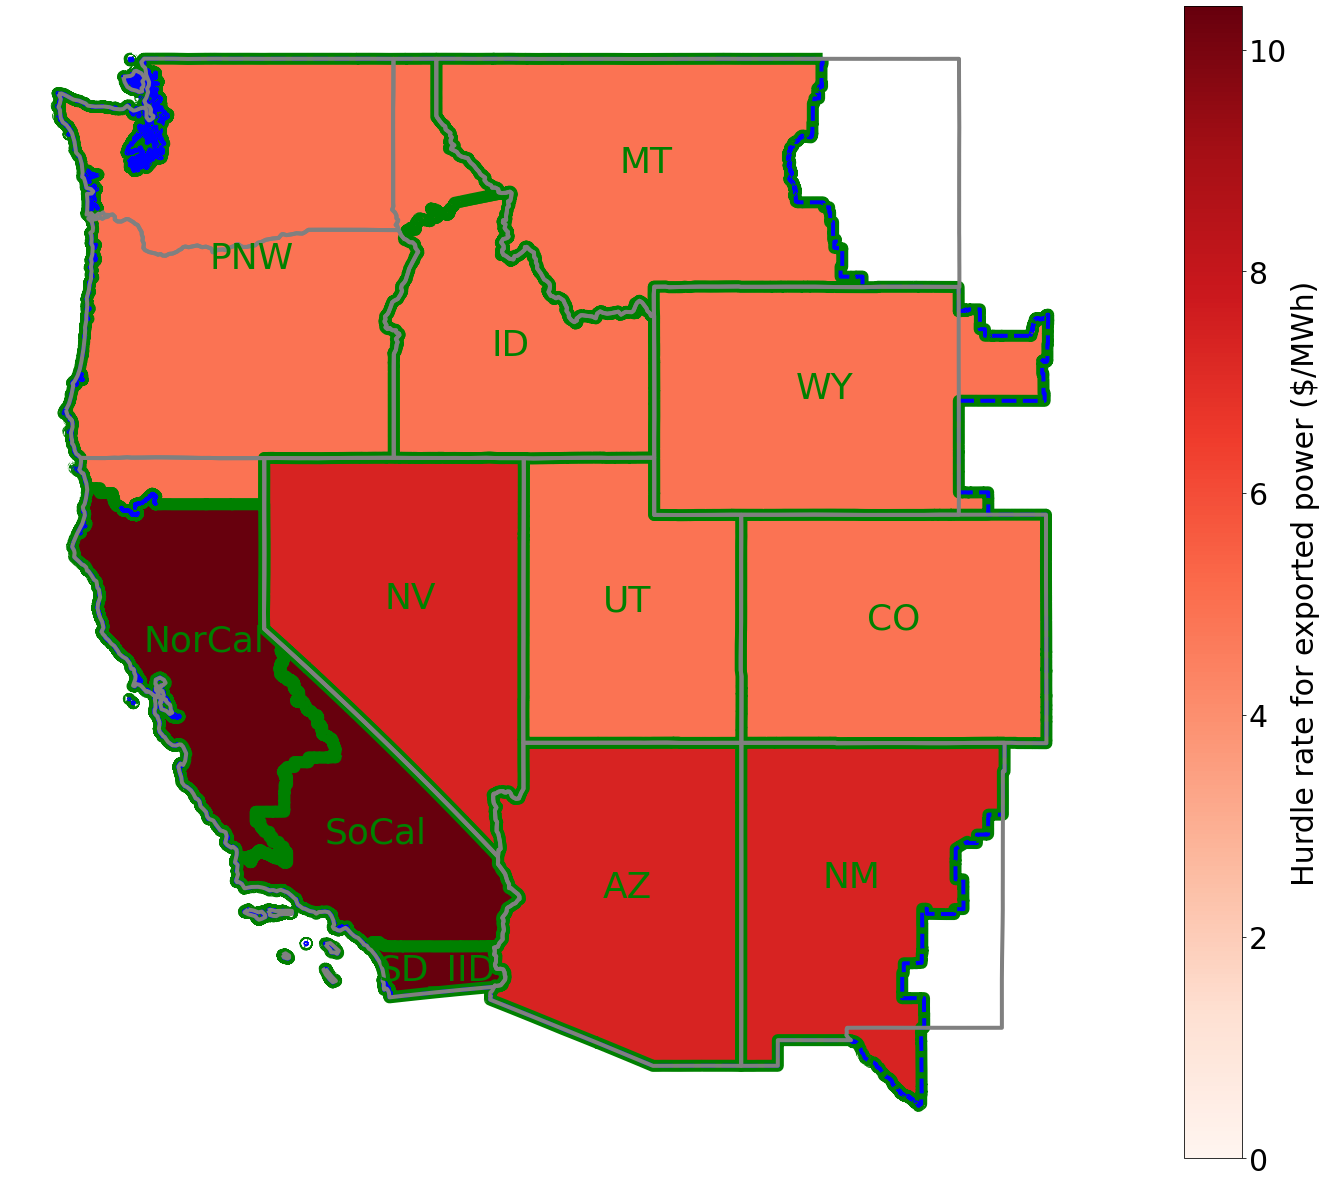

In [66]:
matplotlib.rcParams['font.size'] = 30

fig = plt.figure()

ax = fig.add_axes([0, 0, 4, 4])
wecczone_shapes.plot(ax = ax, cmap = 'Reds', column = wecczone_shapes.Rate_From, 
                     edgecolor = 'green', linewidth = 12, legend = True, vmin = 0,
                     legend_kwds = {'label': "Hurdle rate for exported power ($/MWh)"})
wecczone_shapes.loc[wecczone_shapes['WECC'] == 1].dissolve('WECC').plot(ax = ax, 
                    facecolor = 'none', edgecolor = 'blue', linewidth = 4, linestyle = '--') # facecolor = 'none' makes background none
# wecc1.loc[wecc1['WECC'] == 1].dissolve('WECC').plot(ax = ax, 
#                     facecolor = 'none', edgecolor = 'blue', linewidth = 4, linestyle = '--') # facecolor = 'none' makes background none
# wecc2.loc[wecc2.STATE == 'UT'].dissolve('STATE').plot(ax = ax, 
#                     facecolor = 'none', edgecolor = 'blue', linewidth = 4, linestyle = '--') # facecolor = 'none' makes background none
wecc_states.plot(ax = ax, facecolor = 'none', edgecolor = 'gray', linewidth = 4)

for xy, label in zip(wecczone_shapes.geometry, wecczone_shapes.Regions):
    if label != 'SD_IID':
        ax.annotate(label, xy = xy.centroid.coords[0], fontsize = 36, ha = 'center', color = 'green',
                     bbox = {'facecolor': 'white', 'alpha': 0, 'pad': 2, 'edgecolor': 'none'})
    else:
        ax.annotate(label, xy = (xy.centroid.coords[0][0], xy.centroid.coords[0][1] - 0.2), 
                    fontsize = 36, ha = 'center', color = 'green',
                    bbox = {'facecolor': 'white', 'alpha': 0, 'pad': 2, 'edgecolor': 'none'})

ax.axis('off')

fig = fig.get_figure()
fig.savefig(os.path.join(resultpath, "Regionalization paper/modeling_zones.pdf"))

### Heat map of exports in 100% CES + BAU scenario

In [53]:
flow = pd.read_csv(os.path.join(resultfolder_5, "vFLOW_results.csv"))
del flow['Index']
flow = flow.set_index('Path')
flow = flow / 1000

In [54]:
sample_weight = np.repeat(load.Sub_Weights.dropna().tolist() / load.Timesteps_per_Rep_Period.dropna()[0], load.Timesteps_per_Rep_Period.dropna()[0])

In [55]:
weighted_flow  = flow.mul(sample_weight, axis=1)

In [56]:
export_map = pd.DataFrame(np.zeros((len(regiondf), len(regiondf))))
export_map.set_axis(regiondf.Region, axis = 1, inplace = True)
export_map.set_axis(regiondf.Region, axis = 0, inplace = True)
export_map.reset_index(inplace=True)

In [57]:
for index, row in linenum.iterrows():
    
    if (weighted_flow.iloc[index].name.split('_')[0] != 'SD') & (weighted_flow.iloc[index].name.split('_')[2] != 'SD'):
        szone = weighted_flow.iloc[index].name.split('_')[0]
        ezone = weighted_flow.iloc[index].name.split('_')[2]
    
    if weighted_flow.iloc[index].name.split('_')[0] == 'SD':
        szone = str(weighted_flow.iloc[index].name.split('_')[0] + '_' + weighted_flow.iloc[index].name.split('_')[1])
        ezone = weighted_flow.iloc[index].name.split('_')[3]
    elif weighted_flow.iloc[index].name.split('_')[2] == 'SD':
        szone = weighted_flow.iloc[index].name.split('_')[0]
        ezone = str(weighted_flow.iloc[index].name.split('_')[2] + '_' + weighted_flow.iloc[index].name.split('_')[3])
    
    scode = regiondf[regiondf.Region == szone].Code.tolist()[0]
    ecode = regiondf[regiondf.Region == ezone].Code.tolist()[0]
    
    multiplier = linenum.iloc[index][scode]
    
    export_index = export_map[export_map.Region == szone].index[0]
    export_map.at[export_index, ezone] = export_map.at[export_index, ezone] + sum(weighted_flow.iloc[index] * multiplier)

In [58]:
export_map = export_map.set_index('Region')

In [59]:
emask = np.zeros((len(export_map), len(export_map)))
emask[np.tril_indices_from(emask)] = True

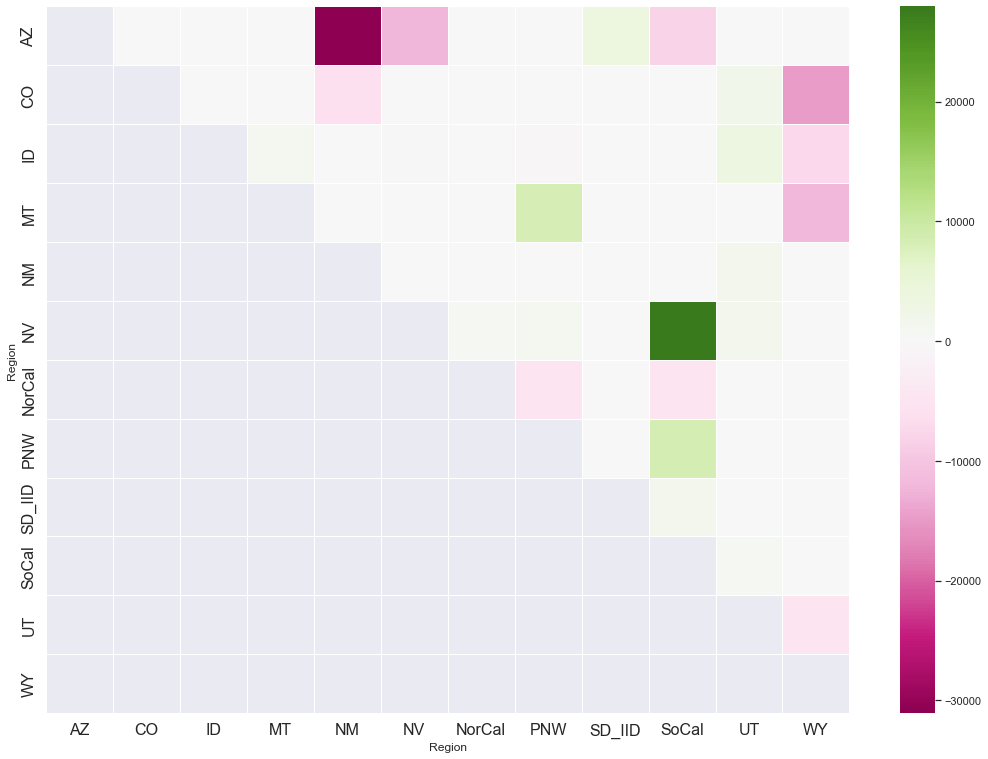

In [60]:
sfig = sns.heatmap(export_map, linewidths = .5, cmap = "PiYG", mask = emask, center=0)
sns.set(rc = {'figure.figsize':(18,13)})
sfig.set_xticklabels(sfig.get_xmajorticklabels(), fontsize = 16)
sfig.set_yticklabels(sfig.get_xmajorticklabels(), fontsize = 16)
plt.savefig(os.path.join(resultpath, "Regionalization paper", "export_regions_pregionalces_rregionalized.pdf"), 
            dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### Four panel figure

In [24]:
four_panel_df = pd.DataFrame()
four_panel_df['VRE'] = [(scn['SOLAR'] + scn['WIND']).sum() for scn in aggregated_cap_scenario]
four_panel_df['Storage'] = (storage_cap['Existing GWh'] + storage_cap['New Build GWh']).to_list()
four_panel_df['Firm Low Carbon'] = [(scn['BIOPOWER'] + scn['NONCCS_COAL'] + scn['CCS_COAL'] + scn['GEOTHERMAL'] + scn['NONCCS_GAS'] +
                                    scn['CCS_GAS'] + scn['HYDRO'] + scn['NUCLEAR'] + scn['OTHER']).sum() for scn in aggregated_cap_scenario]
four_panel_df['Transmission'] = (transmission_df['Existing'] + transmission_df['Expansion']).to_list()
four_panel_df.index = scenario_names

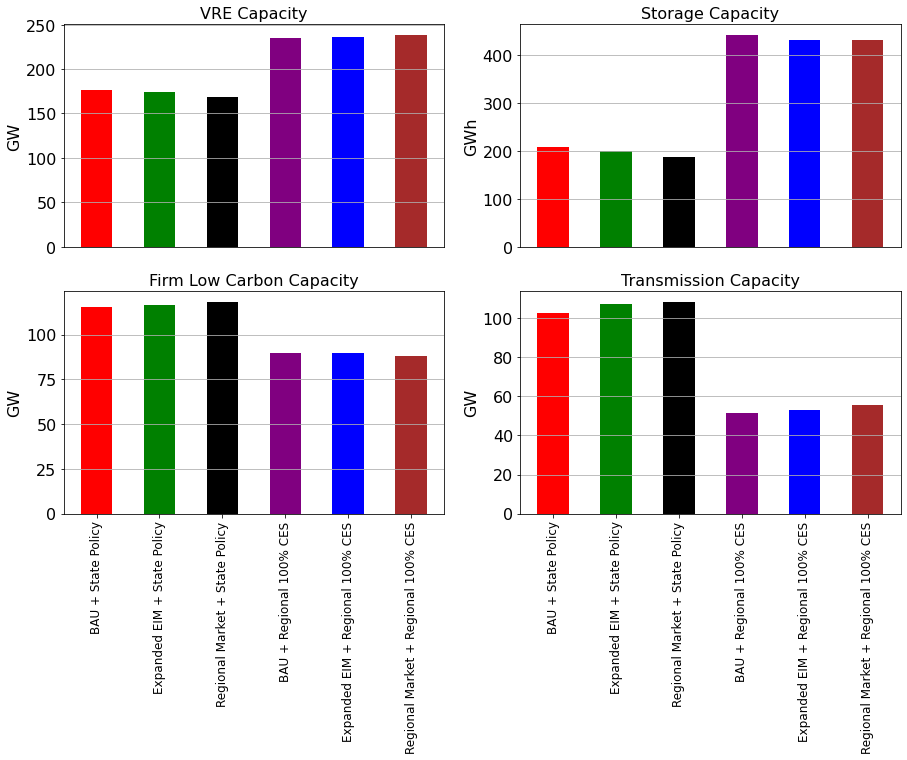

In [27]:
fig, ax = plt.subplots(2, 2, figsize = (fig1, fig2))

ax[0,0].bar(four_panel_df.index, four_panel_df.VRE, width = bar_width, color = color_scenarios)
ax[0,1].bar(four_panel_df.index, four_panel_df.Storage, width = bar_width, color = color_scenarios)
ax[1,0].bar(four_panel_df.index, four_panel_df['Firm Low Carbon'], width = bar_width, color = color_scenarios)
ax[1,1].bar(four_panel_df.index, four_panel_df['Transmission'], width = bar_width, color = color_scenarios)

ax[0,0].set_title('VRE Capacity', fontsize = fs)
ax[0,1].set_title('Storage Capacity', fontsize = fs)
ax[1,0].set_title('Firm Low Carbon Capacity', fontsize = fs)
ax[1,1].set_title('Transmission Capacity', fontsize = fs)

for x in [0,1]:
    for y in [0,1]:
        ax[x,y].tick_params(axis = 'y', labelsize = fs)
        ax[x,y].yaxis.grid()
        if (x == 0) & (y == 1):
            ax[x,y].set_ylabel('GWh', fontsize = fs)
        else:
            ax[x,y].set_ylabel('GW', fontsize = fs)
        
        if x == 0:
            ax[x,y].set_xticks([])
        else:
            ax[x,y].tick_params(axis = 'x', labelsize = 12, rotation = 90)

plt.savefig(os.path.join(resultpath, "Regionalization paper", "four_panel_summary.pdf"), dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### GHG emission

In [51]:
from functools import reduce

In [52]:
week_weights = np.array(load.Sub_Weights.dropna() / load.Timesteps_per_Rep_Period.dropna()[0])
generators.sort_values(by = 'R_ID', inplace = True)
generators_commit = generators[generators['Commit'] == 1]
generators_commit.reset_index(inplace = True)

In [53]:
all_dataframe = []
all_dataframe_start = []
for resfol, sname in zip(resultfolders, scenario_names):
    
    detailed_dispatch = pd.read_csv(os.path.join(resfol, "vGENDISPATCH_results.csv"))
    detailed_dispatch.sort_values(by = 'Index', inplace = True)
    detailed_dispatch.reset_index(inplace = True)
    detailed_dispatch_only_numbers = detailed_dispatch.drop(columns = ['index', 'Index', 'Zone', 'Region', 'Resource'])
    
    detailed_start = pd.read_csv(os.path.join(resfol, "vSTARTUC_results.csv"))
    detailed_start.sort_values(by = 'Index', inplace = True)
    detailed_start.reset_index(inplace = True)
    detailed_start_only_numbers = detailed_start.drop(columns = ['index', 'Index', 'Zone', 'Region', 'Resource'])
#     detailed_start_only_numbers = detailed_start_only_numbers.mul(subset_gen['Cap_Size'], axis = 0)
    detailed_start_only_numbers = detailed_start_only_numbers.mul(generators_commit['Cap_Size'], axis = 0)

    period_sum = detailed_dispatch_only_numbers.groupby((np.arange(len(detailed_dispatch_only_numbers.columns)) // int(load.Timesteps_per_Rep_Period.dropna()[0])) + 1, axis = 1).sum().add_prefix('s')
    period_sum_start = detailed_start_only_numbers.groupby((np.arange(len(detailed_start_only_numbers.columns)) // int(load.Timesteps_per_Rep_Period.dropna()[0])) + 1, axis = 1).sum().add_prefix('p')
    
    granular_co2 = period_sum.mul(generators['CO2_Rate'], axis = 0)
    granular_co2.loc[:, ['s1', 's2', 's3', 's4', 's5', 's6']] *= week_weights
    granular_co2['state'] = detailed_dispatch['Region']
    
#     granular_start = period_sum_start.mul(subset_gen['CO2_Per_Start'], axis = 0)
    granular_start = period_sum_start.mul(generators_commit['CO2_Per_Start'], axis = 0)
    granular_start.loc[:, ['p1', 'p2', 'p3', 'p4', 'p5', 'p6']] *= week_weights
    granular_start['state'] = detailed_start['Region']
    
    final_df = pd.DataFrame(granular_co2.groupby('state')[['s1', 's2', 's3', 's4', 's5', 's6']].sum().sum(axis = 1))
    final_df.columns = [sname]
    all_dataframe.append(final_df)
    
    final_df_start = pd.DataFrame(granular_start.groupby('state')[['p1', 'p2', 'p3', 'p4', 'p5', 'p6']].sum().sum(axis = 1))
    final_df_start.columns = [sname]
    all_dataframe_start.append(final_df_start)
    
ghg_emission = reduce(lambda x, y: pd.merge(x, y, on = 'state'), all_dataframe)
ghg_emission = ghg_emission / 1000000

ghg_emission_start = reduce(lambda x, y: pd.merge(x, y, on = 'state'), all_dataframe_start)
ghg_emission_start = ghg_emission_start / 1000000

ghg_for_plot = ghg_emission + ghg_emission_start

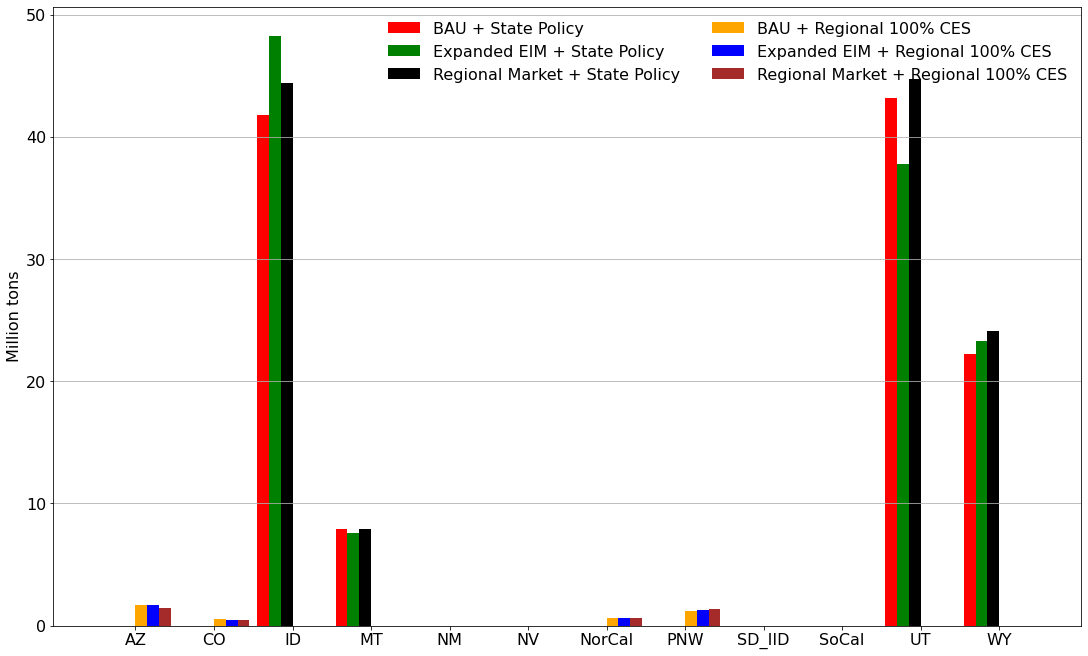

In [54]:
ind = np.arange(len(ghg_for_plot))

fig, ax = plt.subplots(1, 1, figsize = (fig1, fig2), constrained_layout = True)

bar_width = 0.15
linew = 7

for index, scename in enumerate(ghg_for_plot):
    
    ax.bar(ind + bar_width * index, ghg_for_plot[scename], width = bar_width,  color = color_scenarios[index], label = scename)
    
ax.set_ylabel('Million tons', fontsize = fs)
ax.tick_params(axis = 'y', labelsize = fs)
ax.tick_params(axis = 'x', labelsize = fs)
ax.yaxis.grid()
ax.set_xticks(ind + 5 * bar_width / 2)
ax.set_xticklabels(ghg_for_plot.index)
ax.legend(fontsize = fs, frameon = False, ncol = 2)

plt.savefig(os.path.join(resultpath, "Regionalization paper", "ghg_emission.pdf"), dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)